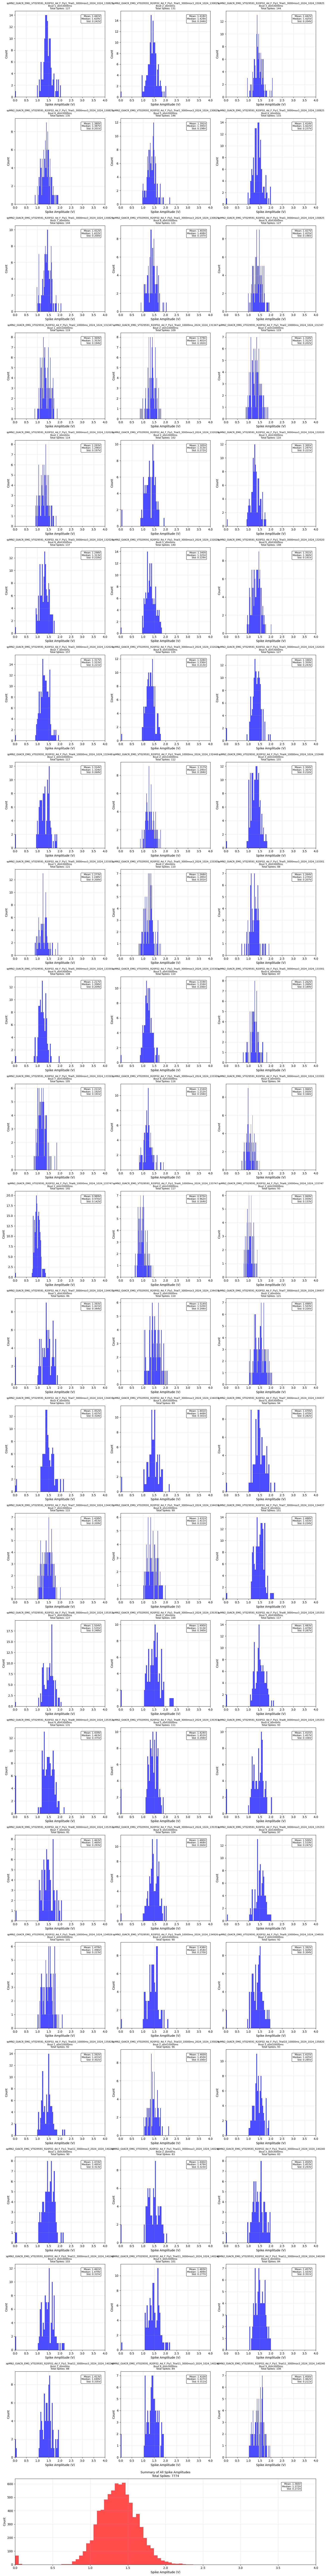

In [27]:
# Step 1, check the spike amplitude histogram, and select (manually) the cut-off threshold for DLMn spikes.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from natsort import natsorted

def plot_all_bouts_in_folder(base_folder_path, bins=50):
    csv_files = []
    all_spike_amplitudes = []
    
    for root, dirs, files in os.walk(base_folder_path):
        for file in files:
            if file.endswith('.csv'):
                csv_files.append(os.path.join(root, file))
    
    csv_files = natsorted(csv_files)
    n_files = len(csv_files)
    n_cols = 3
    n_rows = (n_files + n_cols - 1) // n_cols
    
    fig = plt.figure(figsize=(15, 5*(n_rows + 1)))
    gs = plt.GridSpec(n_rows + 1, n_cols, figure=fig)
    
    # Individual histograms
    for idx, csv_file_path in enumerate(csv_files):
        row = idx // n_cols
        col = idx % n_cols
        ax = fig.add_subplot(gs[row, col])
        
        data = pd.read_csv(csv_file_path)
        spike_amplitudes = data['Spike Amplitude'][data['Spike Count'] == 1]
        all_spike_amplitudes.extend(spike_amplitudes)
        
        ax.hist(spike_amplitudes, bins=bins, color='blue', alpha=0.7)
        ax.set_xlim(0, 4)
        
        if len(spike_amplitudes) > 0:
            mean_amp = np.mean(spike_amplitudes)
            median_amp = np.median(spike_amplitudes)
            std_amp = np.std(spike_amplitudes)
        else:
            mean_amp = median_amp = std_amp = 0
        
        ax.set_xlabel('Spike Amplitude (V)')
        ax.set_ylabel('Count')
        
        csv_filename = os.path.basename(csv_file_path)
        trial_info = csv_filename.split('_bout')[0]
        bout_info = csv_filename.split('_bout')[1].split('.csv')[0]
        
        ax.set_title(f'{trial_info}\nBout {bout_info}\nTotal Spikes: {len(spike_amplitudes)}',
                    fontsize=8)
        
        stats_text = f'Mean: {mean_amp:.3f}V\nMedian: {median_amp:.3f}V\nStd: {std_amp:.3f}V'
        ax.text(0.95, 0.95, stats_text,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # Remove empty subplots
    for idx in range(len(csv_files), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        fig.delaxes(fig.add_subplot(gs[row, col]))
    
    # Summary histogram
    ax_summary = fig.add_subplot(gs[-1, :])
    ax_summary.hist(all_spike_amplitudes, bins=bins, color='red', alpha=0.7)
    ax_summary.set_xlim(0, 4)
    ax_summary.set_xlabel('Spike Amplitude (V)')
    ax_summary.set_ylabel('Count')
    ax_summary.set_title('Summary of All Spike Amplitudes\n'
                        f'Total Spikes: {len(all_spike_amplitudes)}',
                        fontsize=10)
    
    mean_all = np.mean(all_spike_amplitudes)
    median_all = np.median(all_spike_amplitudes)
    std_all = np.std(all_spike_amplitudes)
    stats_text = f'Mean: {mean_all:.3f}V\nMedian: {median_all:.3f}V\nStd: {std_all:.3f}V'
    ax_summary.text(0.95, 0.95, stats_text,
                   transform=ax_summary.transAxes,
                   verticalalignment='top',
                   horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   fontsize=8)
    ax_summary.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Example usage, this is the output_csv folder.
folder_path = '/Users/camellyc/Library/CloudStorage/GoogleDrive-yichen@tuthill.casa/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/Yichen/Spiracle/Spiracle Imaging/EMG_Analysis/2_spMN_GtACR/241024_spMN2_GtACR_EMG_Fly1_Y/output_csv'
plot_all_bouts_in_folder(folder_path)

In [28]:
# Step 2: Filter the spikes and save as csv files, in different subfolders sorted by stimulus length.

import pandas as pd
import numpy as np
import os
import re
from pathlib import Path
from tqdm import tqdm
%run '/Users/camellyc/Library/Mobile Documents/com~apple~CloudDocs/学习/Lab/Tuthill Lab/Codes/Flight_Arena_Analysis/spiracle_helper_functions.py'

def process_spikefiltered_csv(file_path, output_dir, amp_range, sampling_rate = 20000):
    df = pd.read_csv(file_path)
    mask = (df['Spike Count'] == 1)
    outside_range = (df['Spike Amplitude'] < amp_range[0]) | (df['Spike Amplitude'] > amp_range[1])
    df.loc[mask & outside_range, 'Spike Count'] = 0
    df['Spike Rate'] = calculate_spike_rate(df['Spike Count'].values, sampling_rate)
    
    stim_match = re.search(r'stim(\d+)ms', str(file_path))
    if stim_match:
        stim_time = f"{stim_match.group(1)}ms"
        output_subdir = Path(output_dir) / stim_time
        output_subdir.mkdir(exist_ok=True)
        output_path = output_subdir / Path(file_path).name
        df.to_csv(output_path, index=False)

def main():
    min_amp = 0.5
    max_amp = 2.5
    # input path should be the output_csv folder.
    input_path = Path('/Users/camellyc/Library/CloudStorage/GoogleDrive-yichen@tuthill.casa/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/Yichen/Spiracle/Spiracle Imaging/EMG_Analysis/2_spMN_GtACR/241024_spMN2_GtACR_EMG_Fly1_Y/output_csv')
    output_dir = input_path.parent / 'output_csv_spikefiltered'
    output_dir.mkdir(exist_ok=True)
    
    files = list(input_path.glob('*.csv'))
    for file_path in tqdm(files, desc="Processing files"):
        process_spikefiltered_csv(file_path, output_dir, (min_amp, max_amp))

if __name__ == "__main__":
    main()

Processing files: 100%|██████████| 69/69 [03:02<00:00,  2.65s/it]


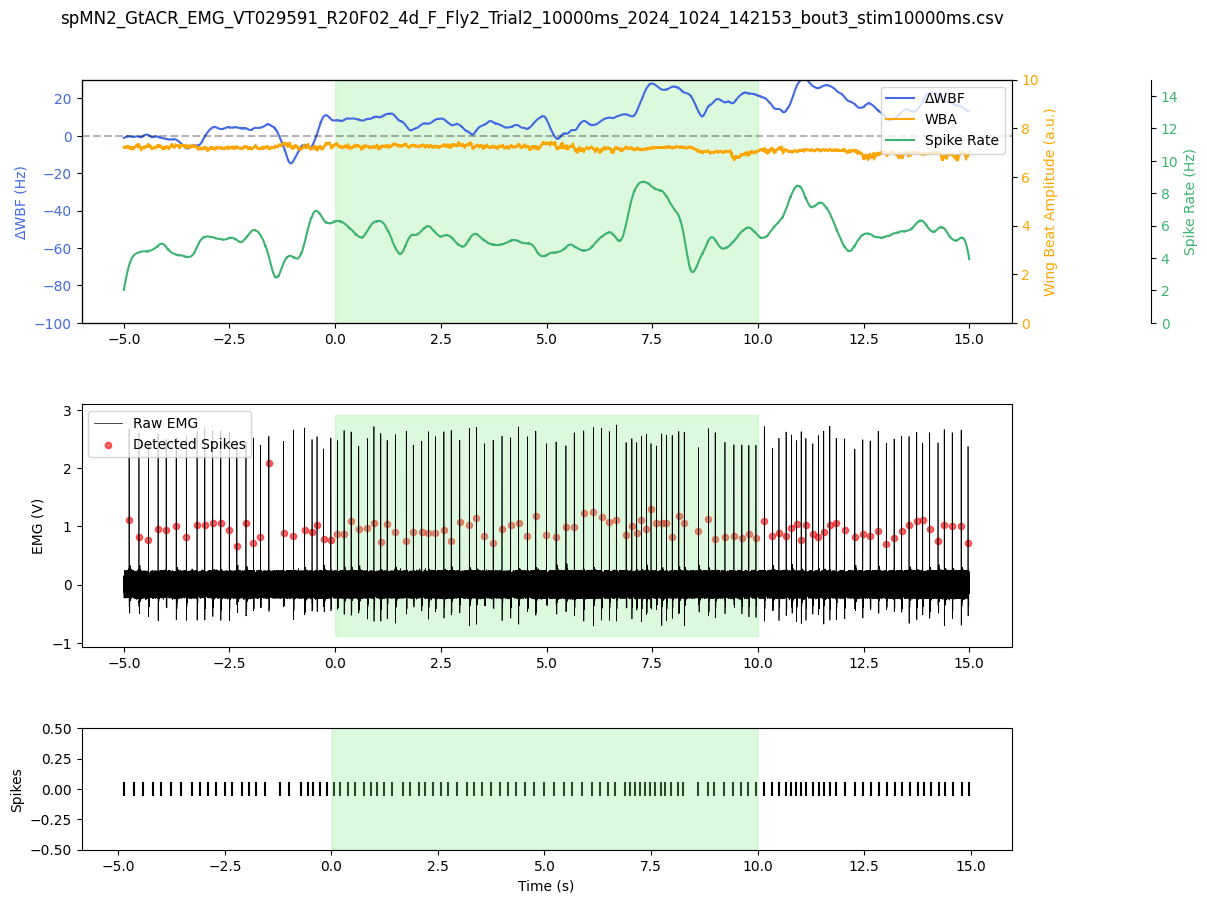

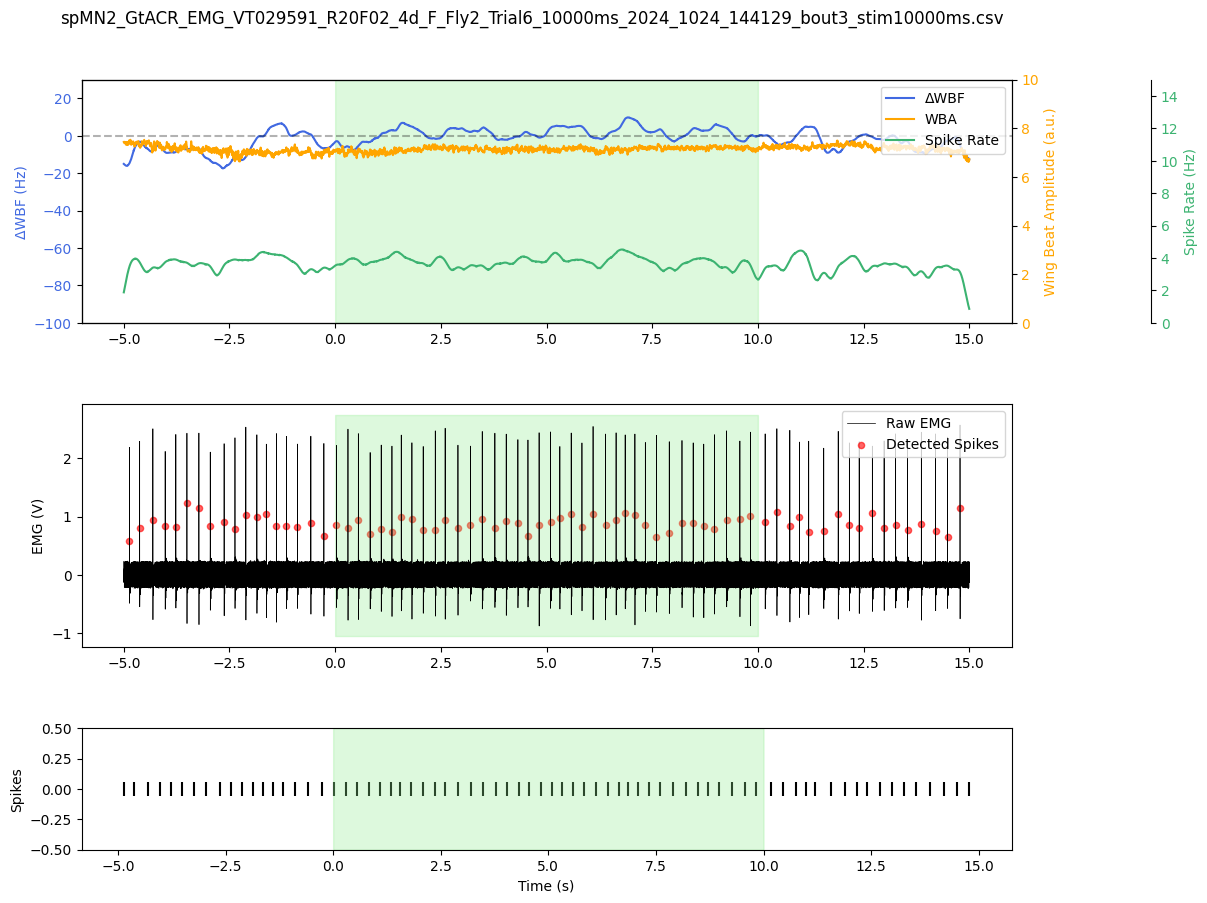

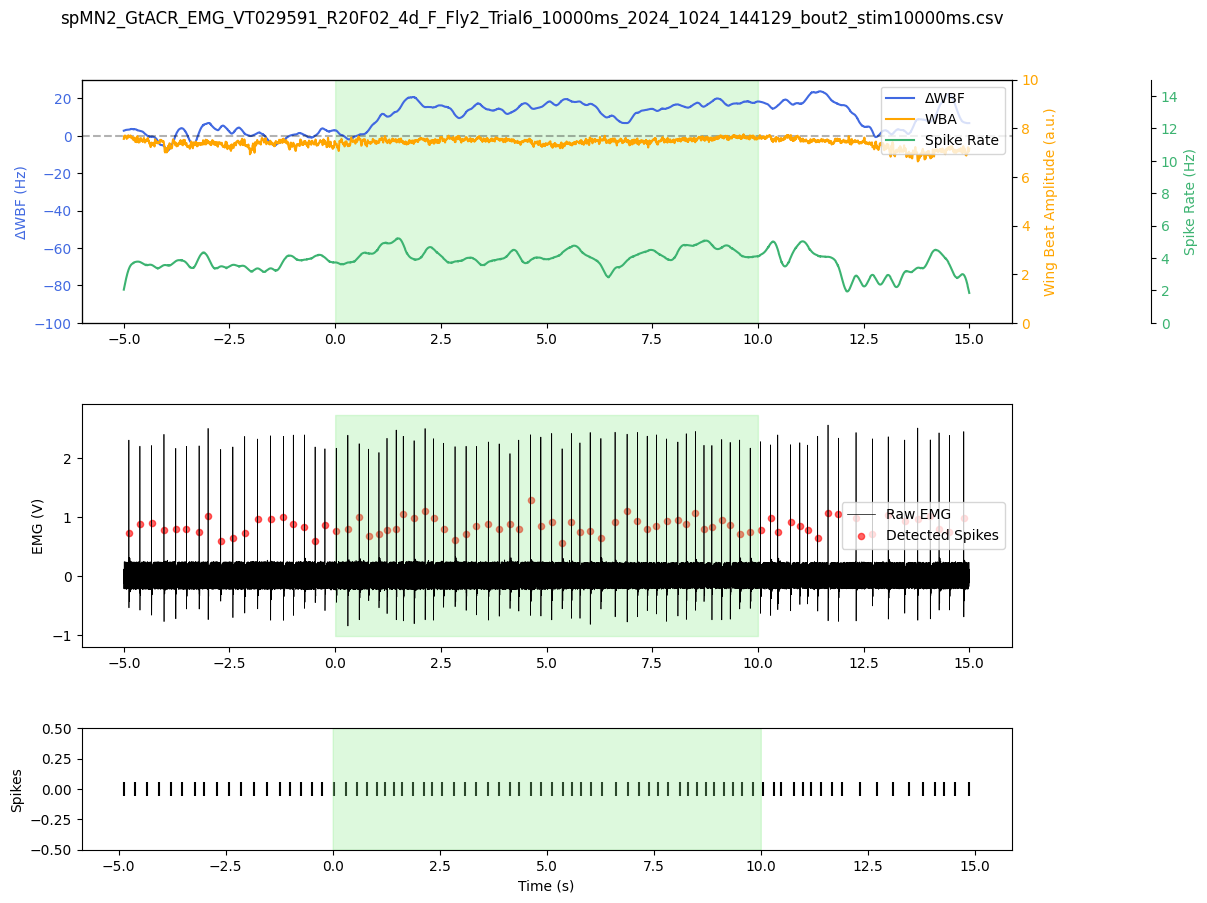

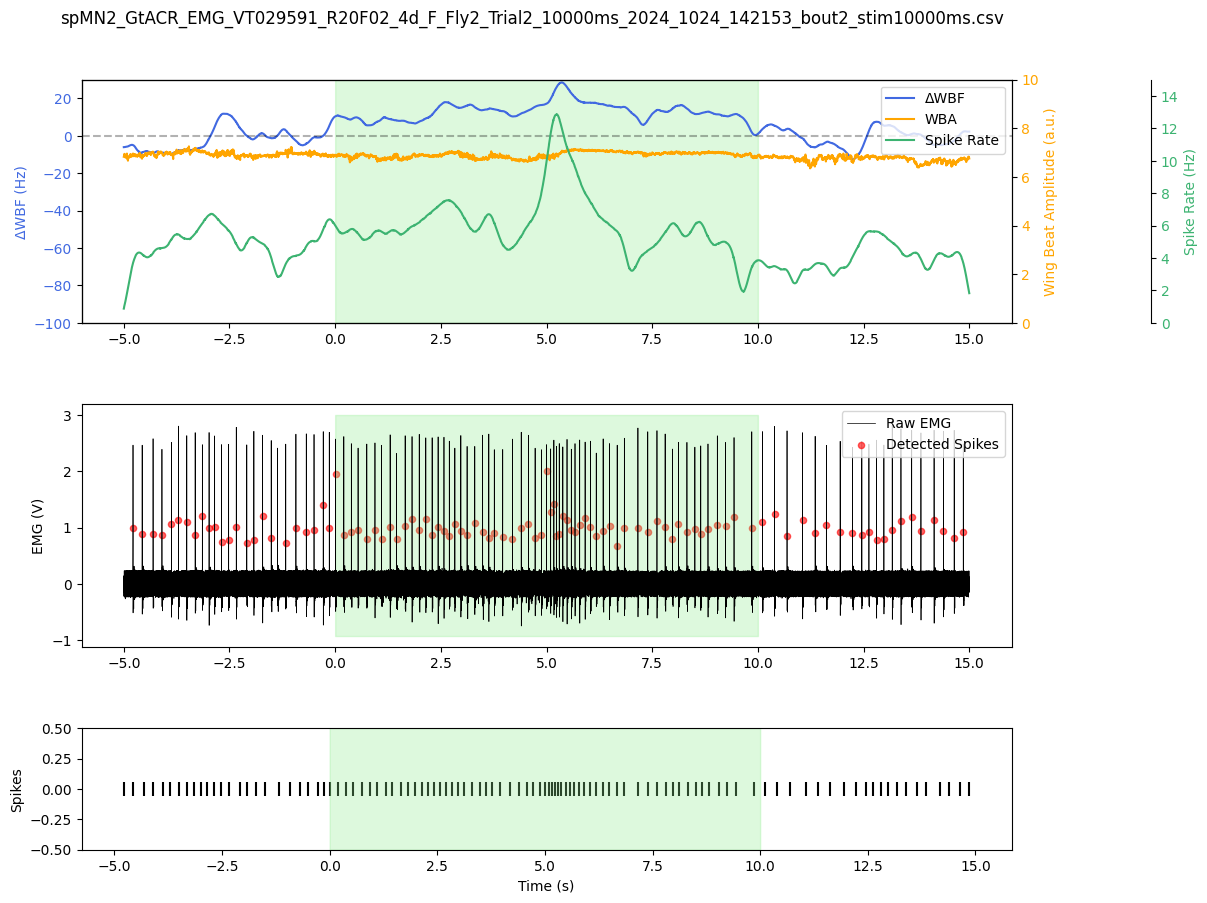

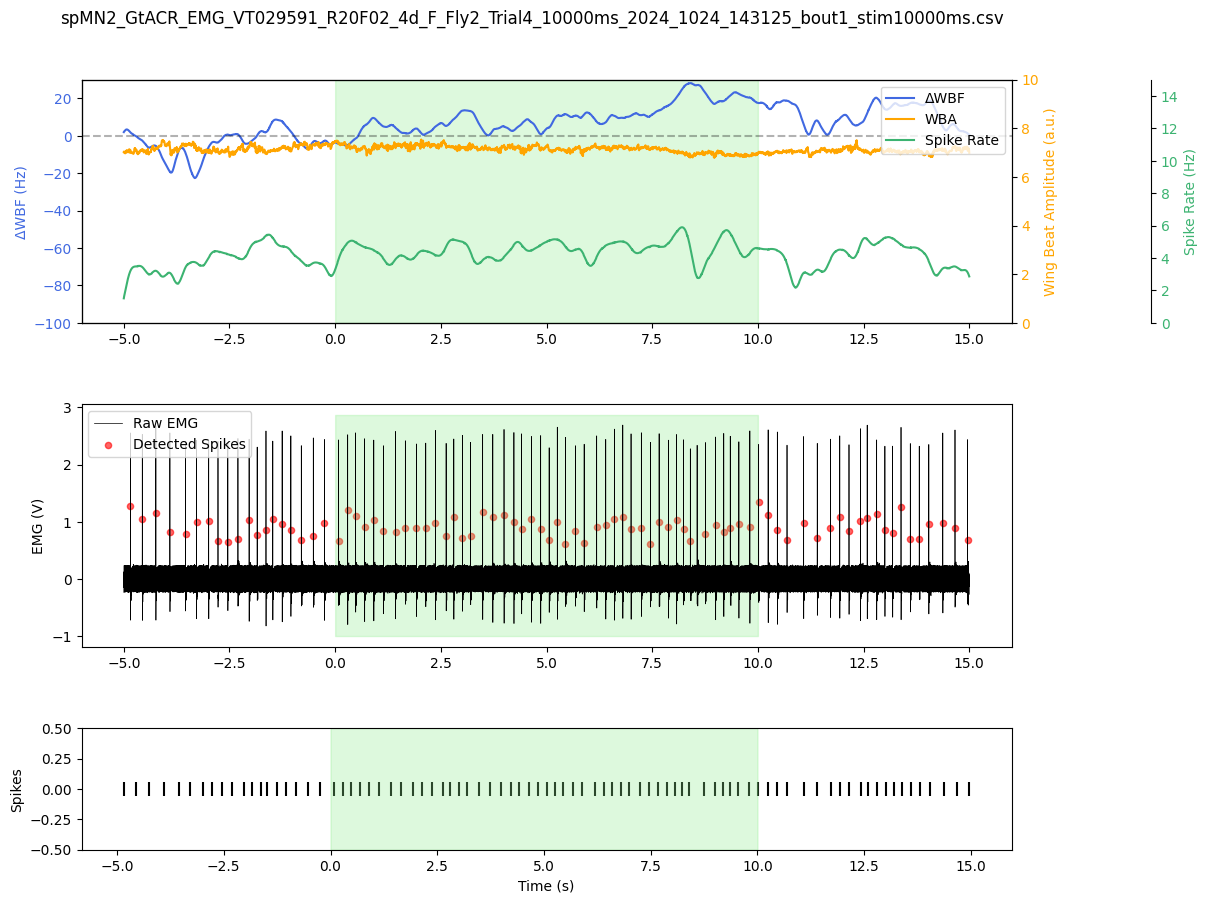

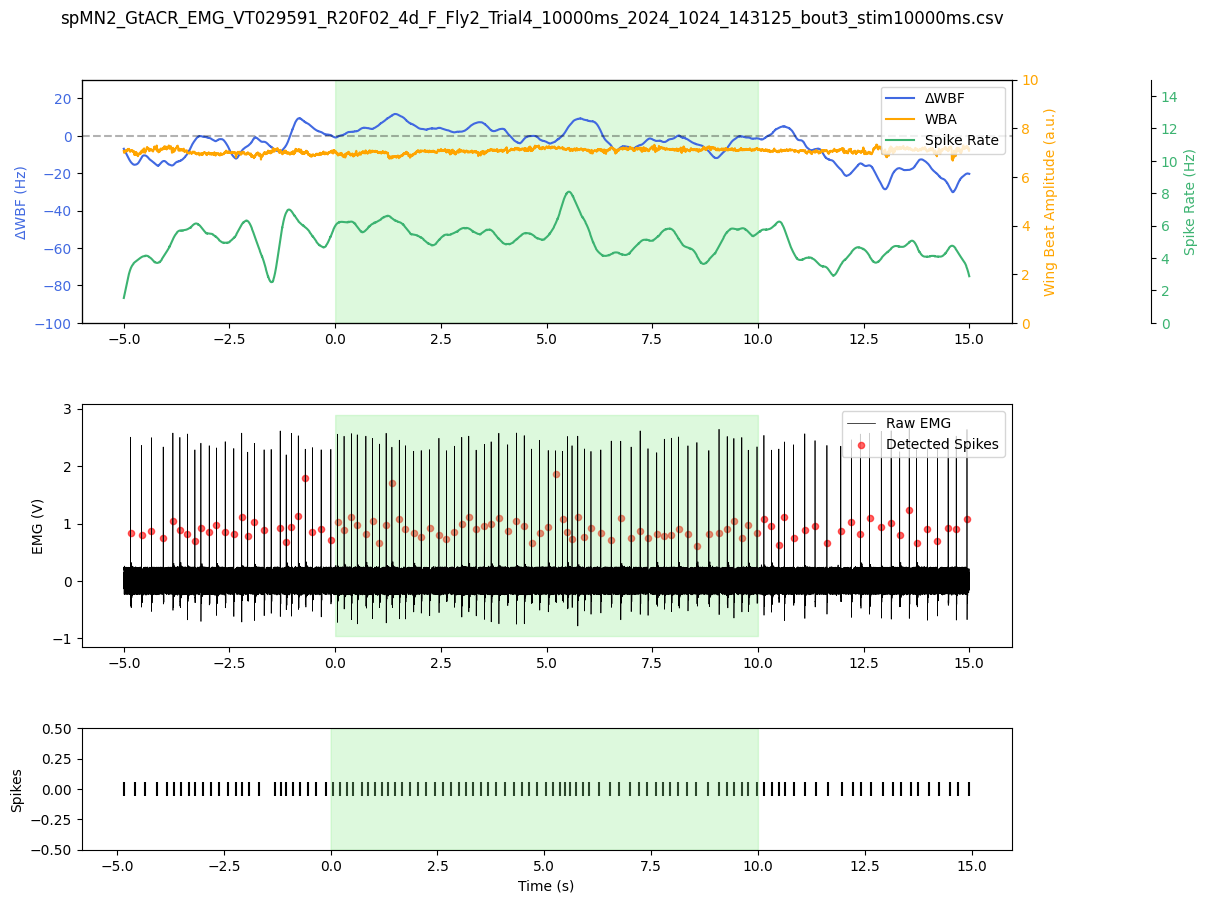

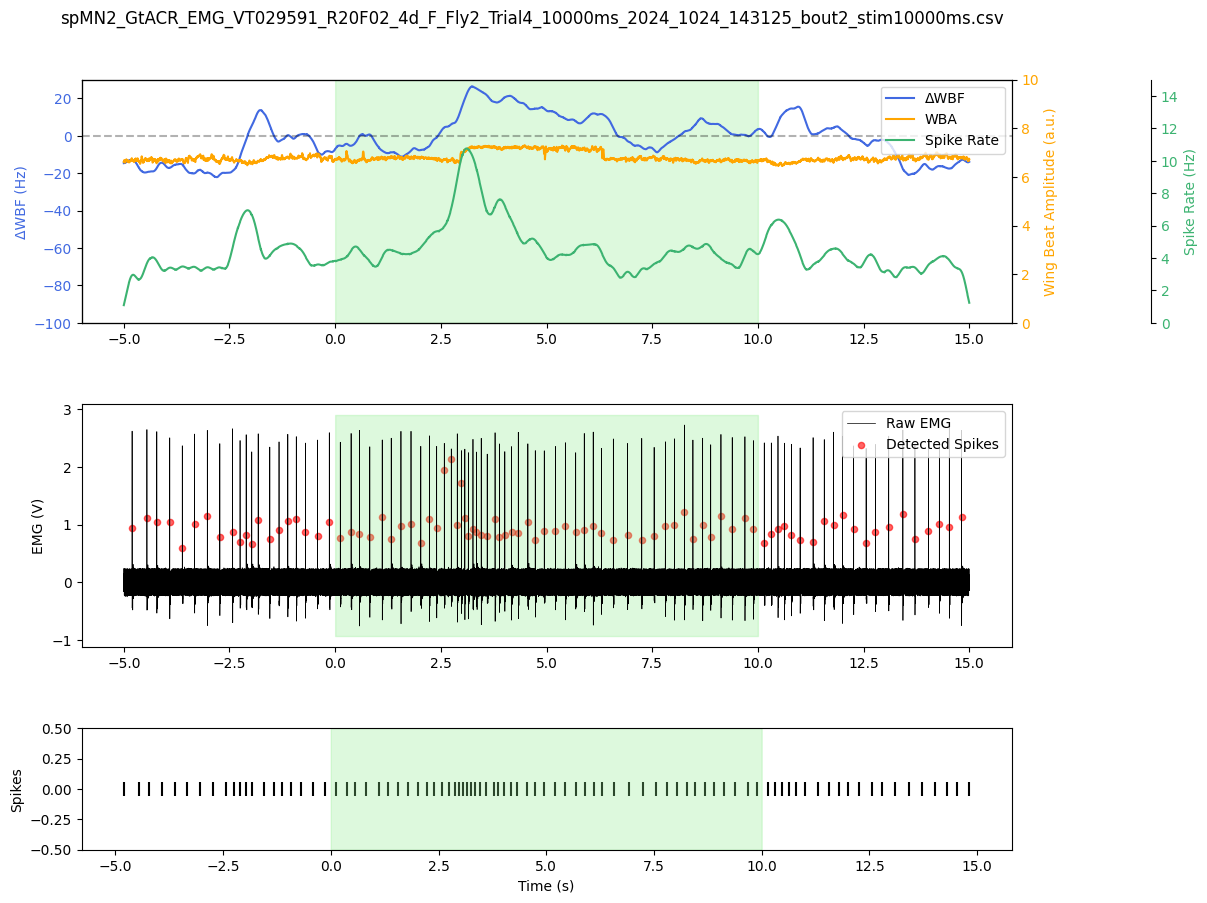

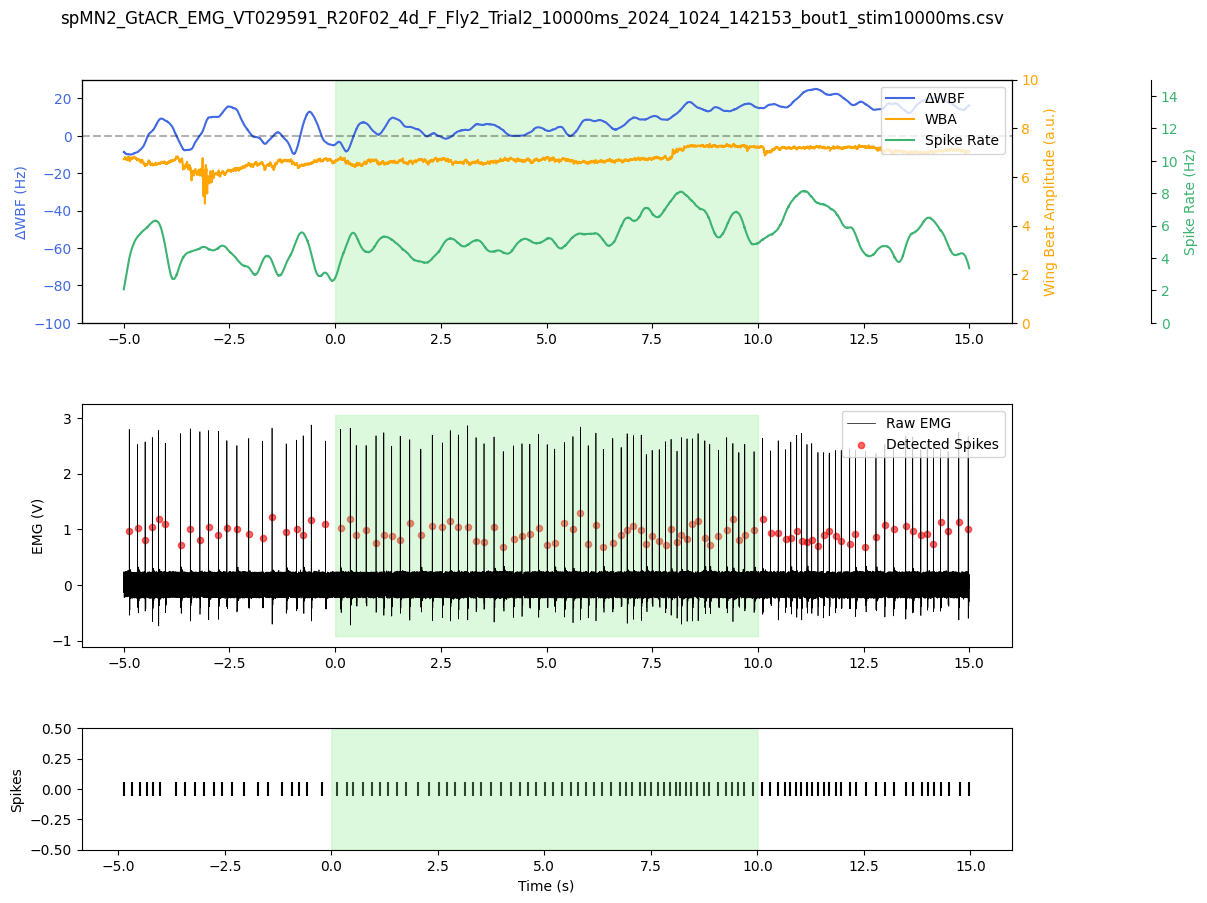

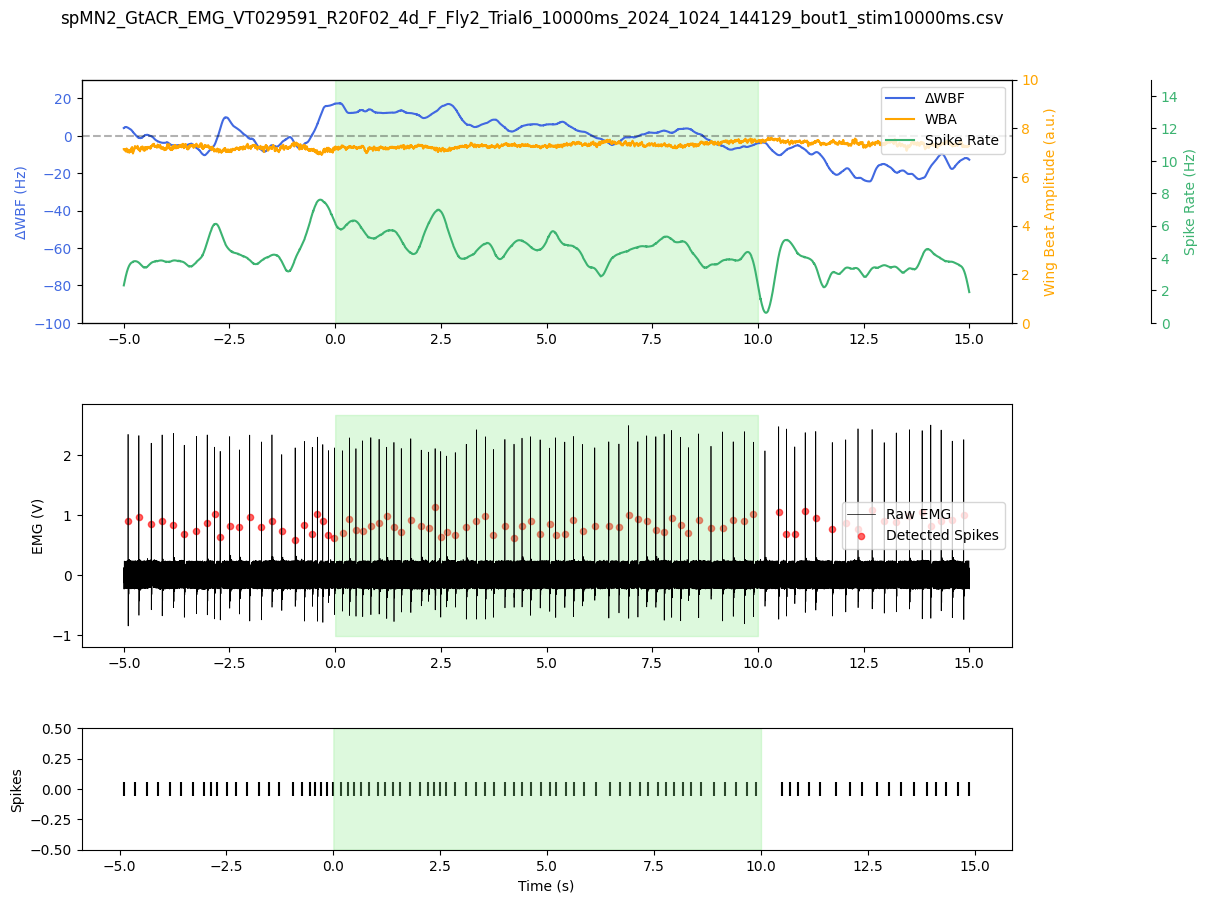

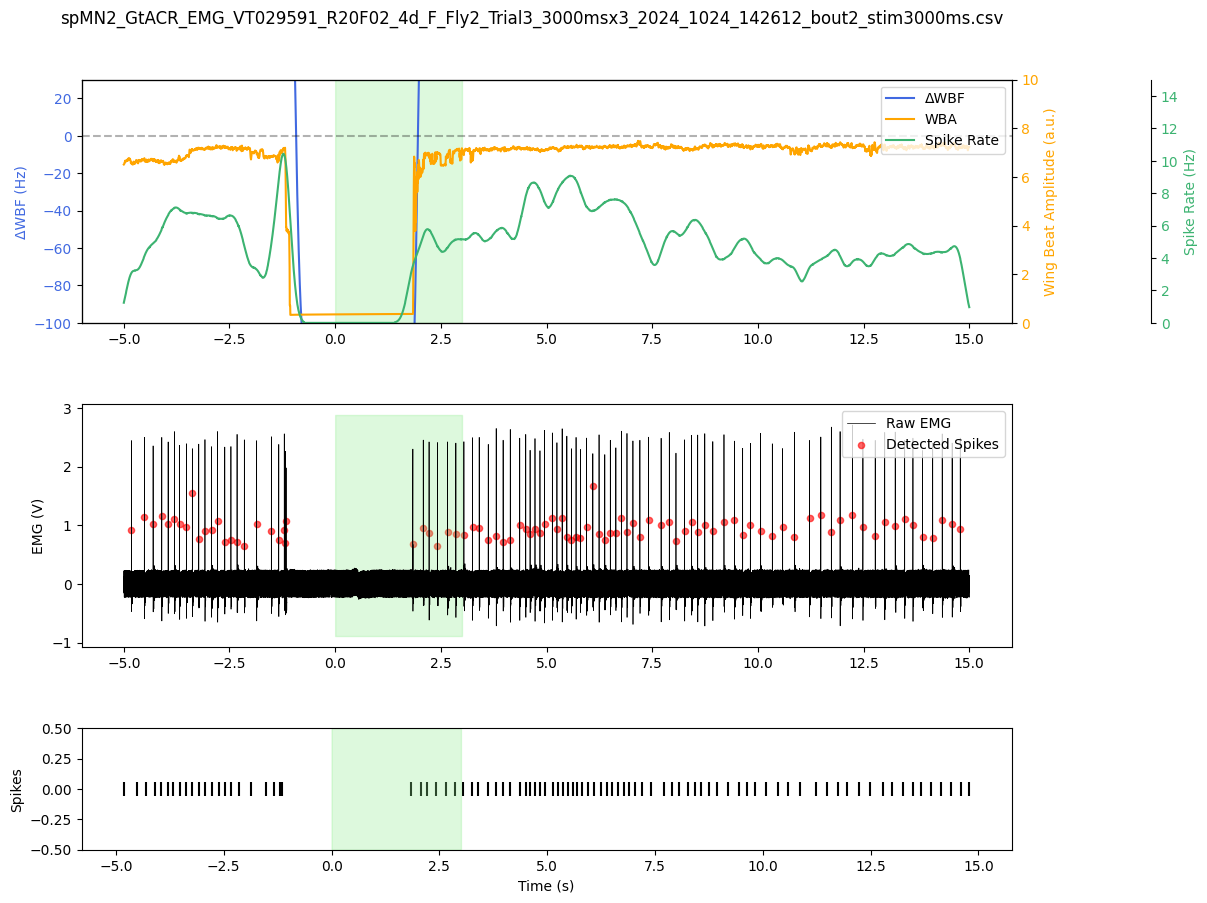

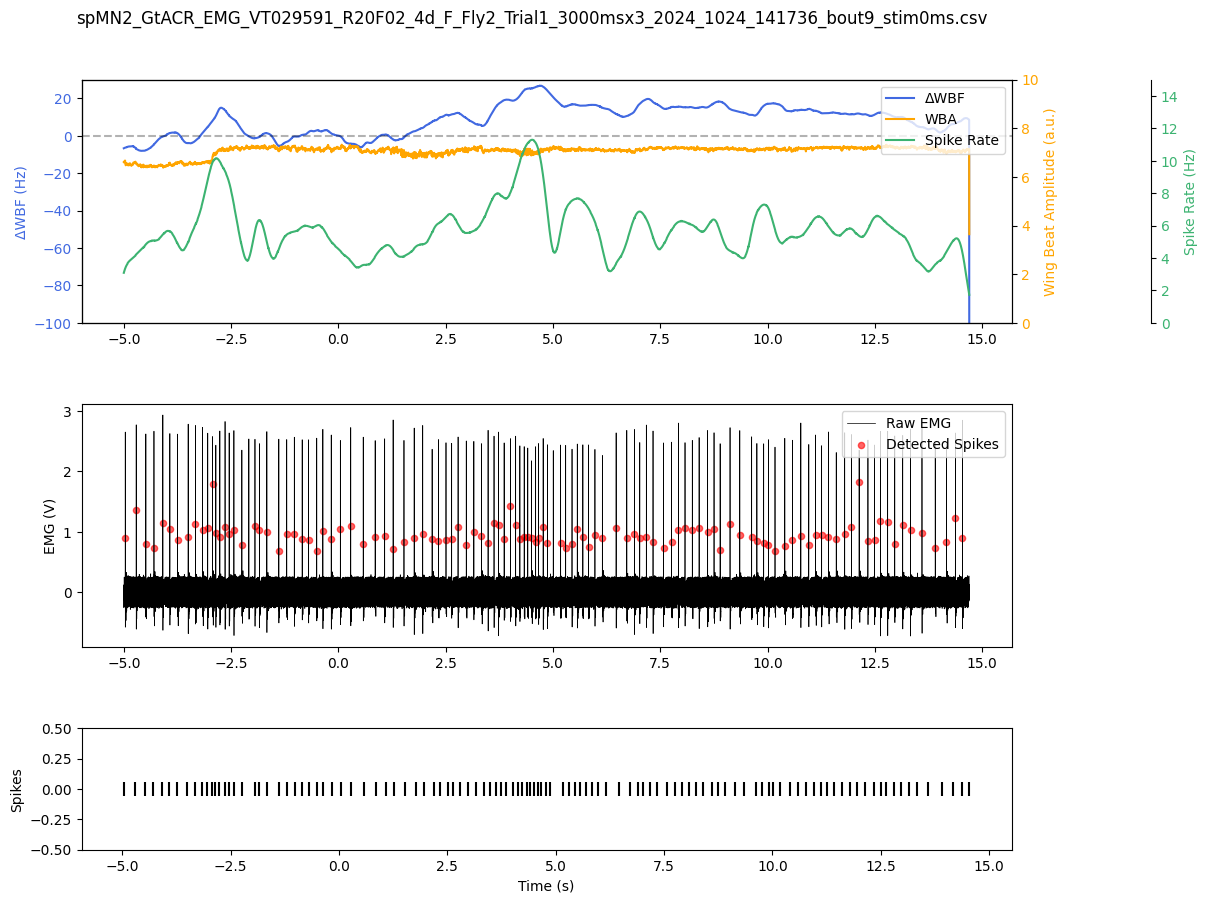

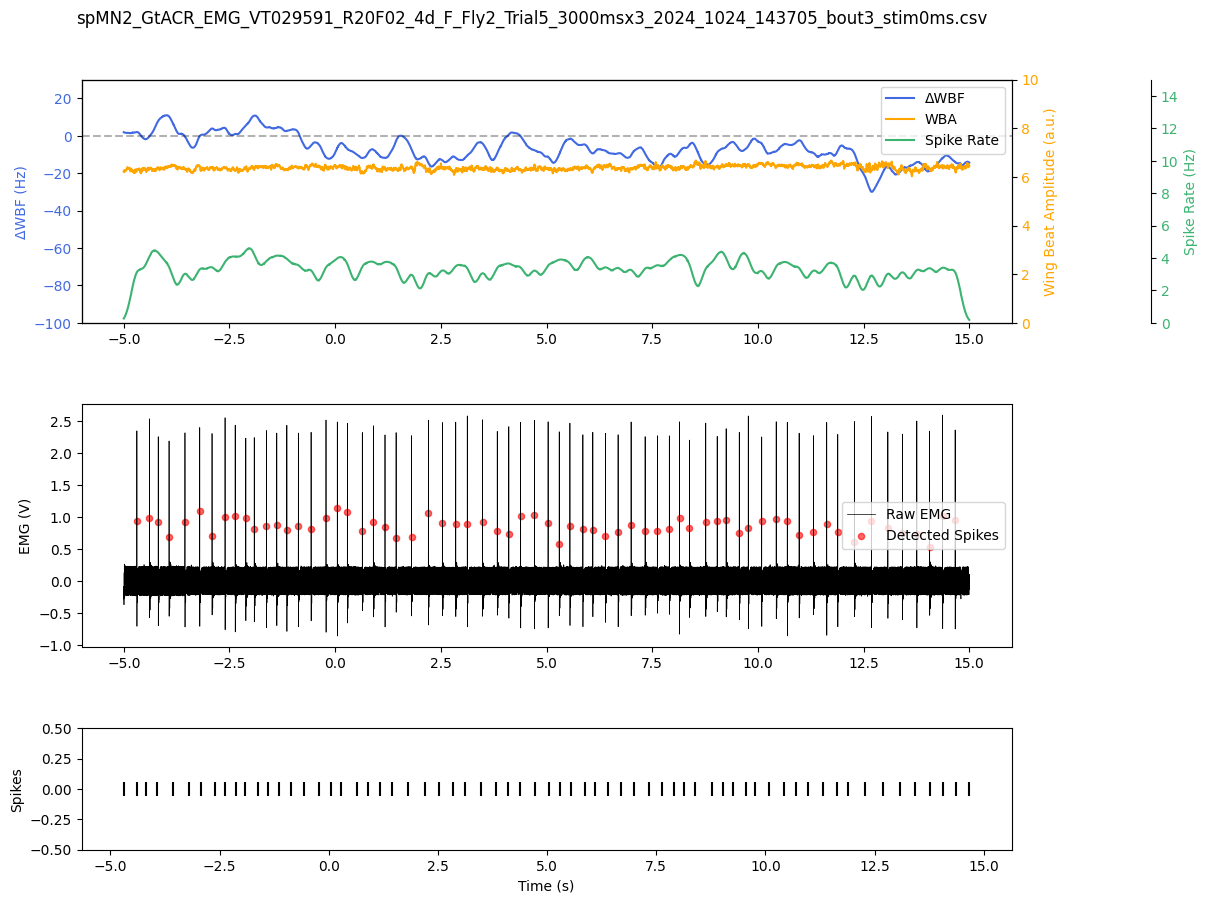

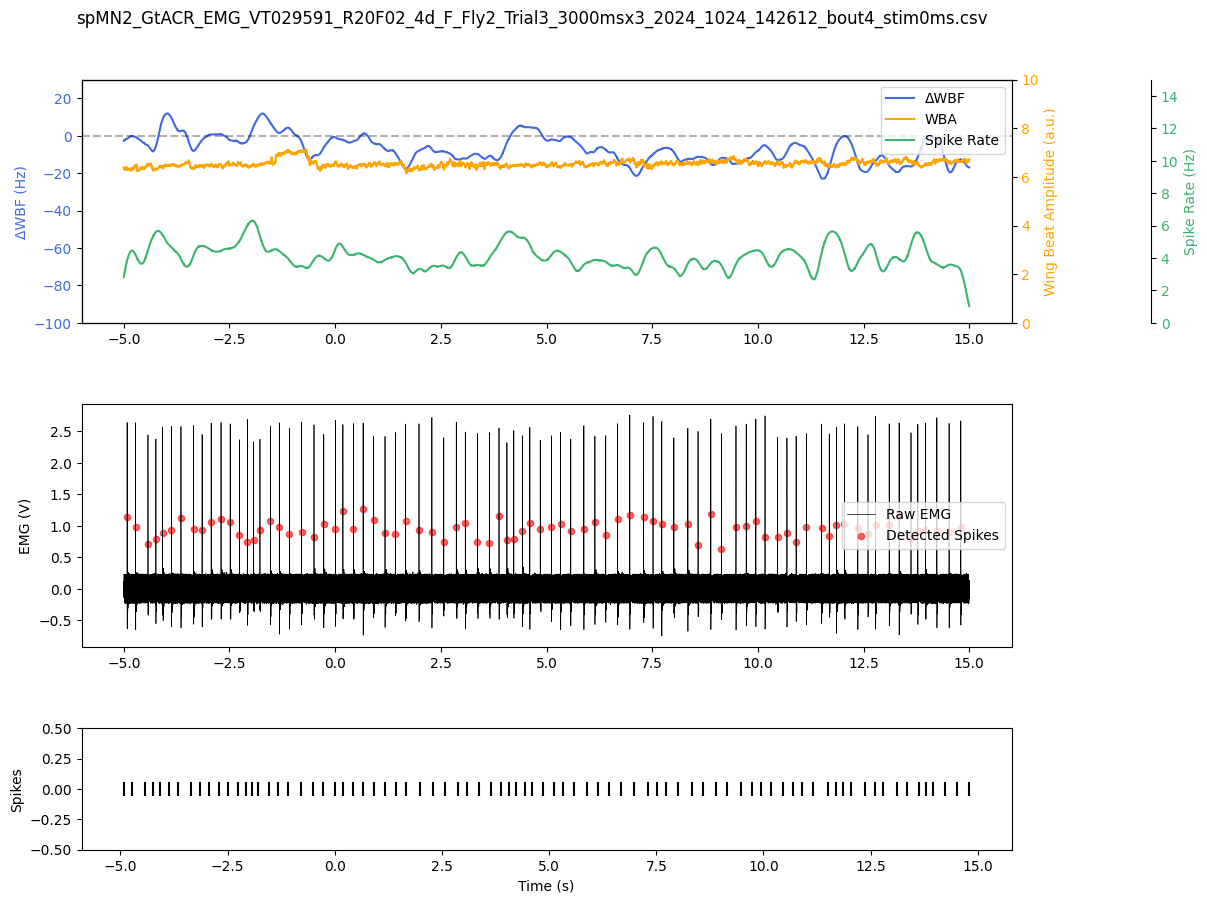

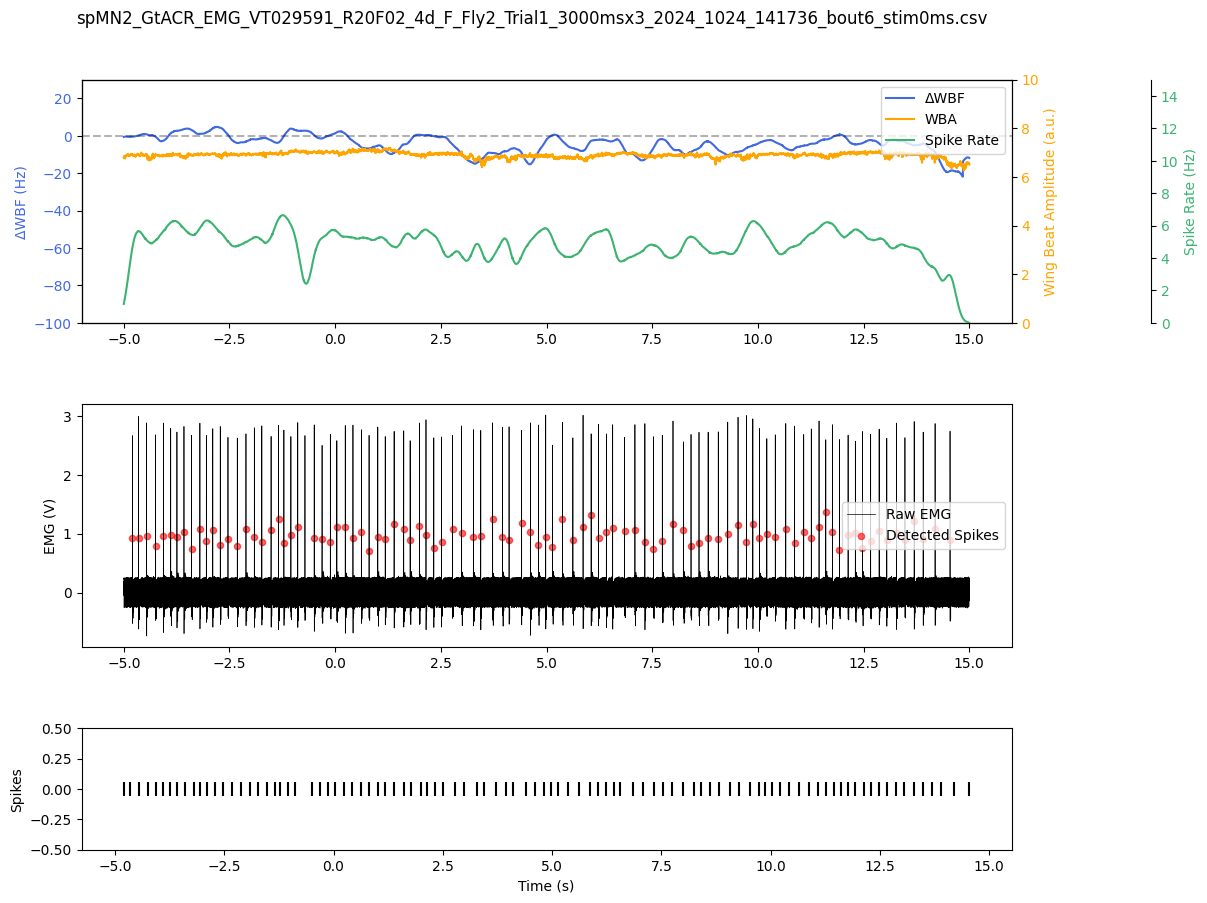

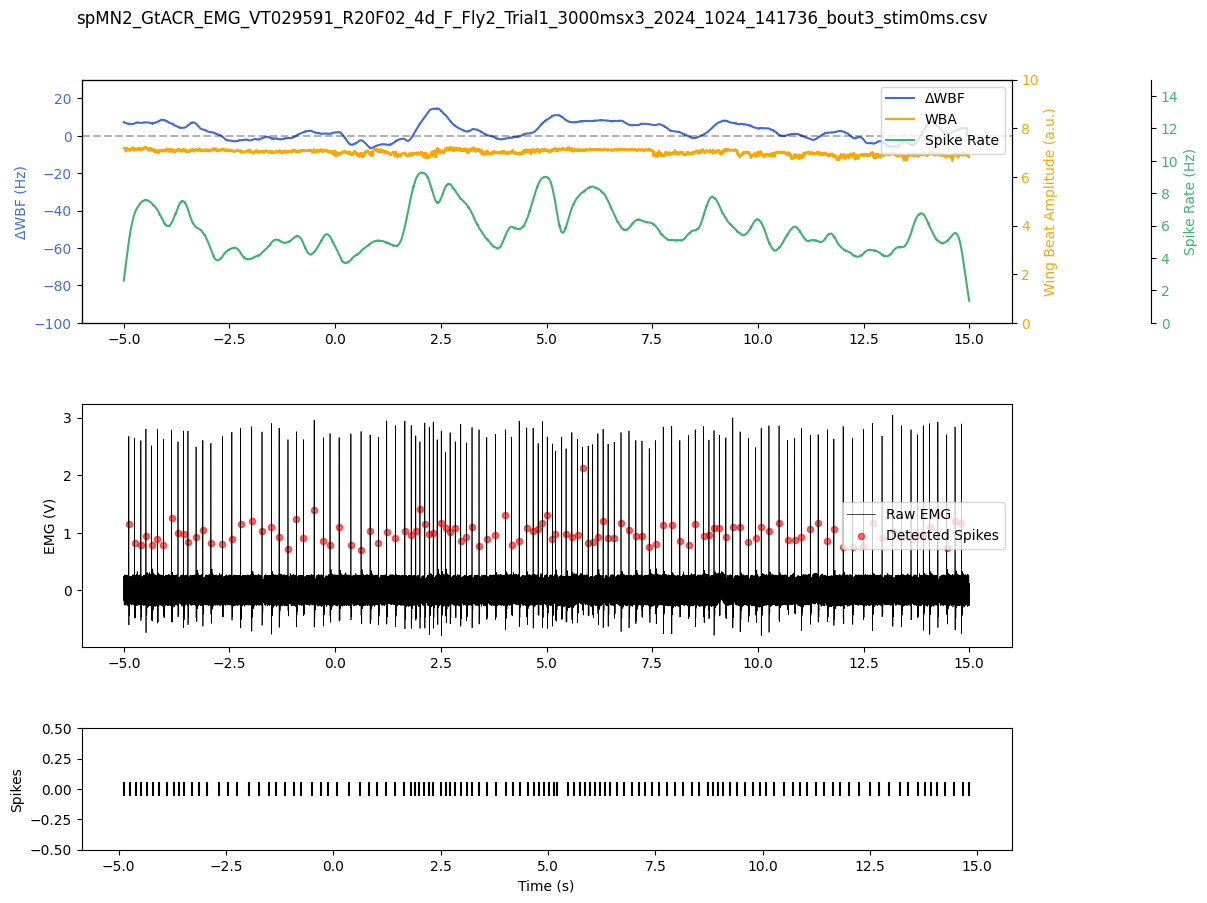

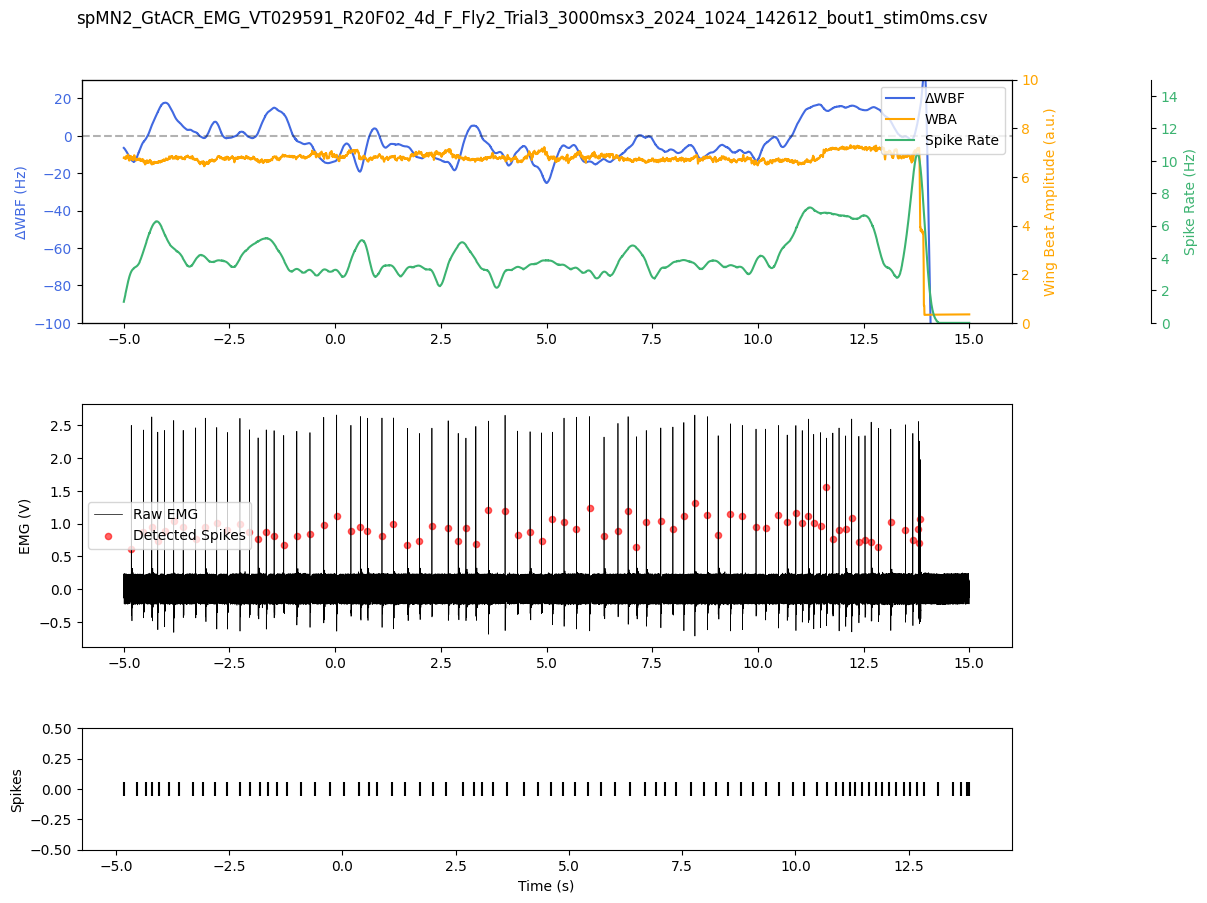

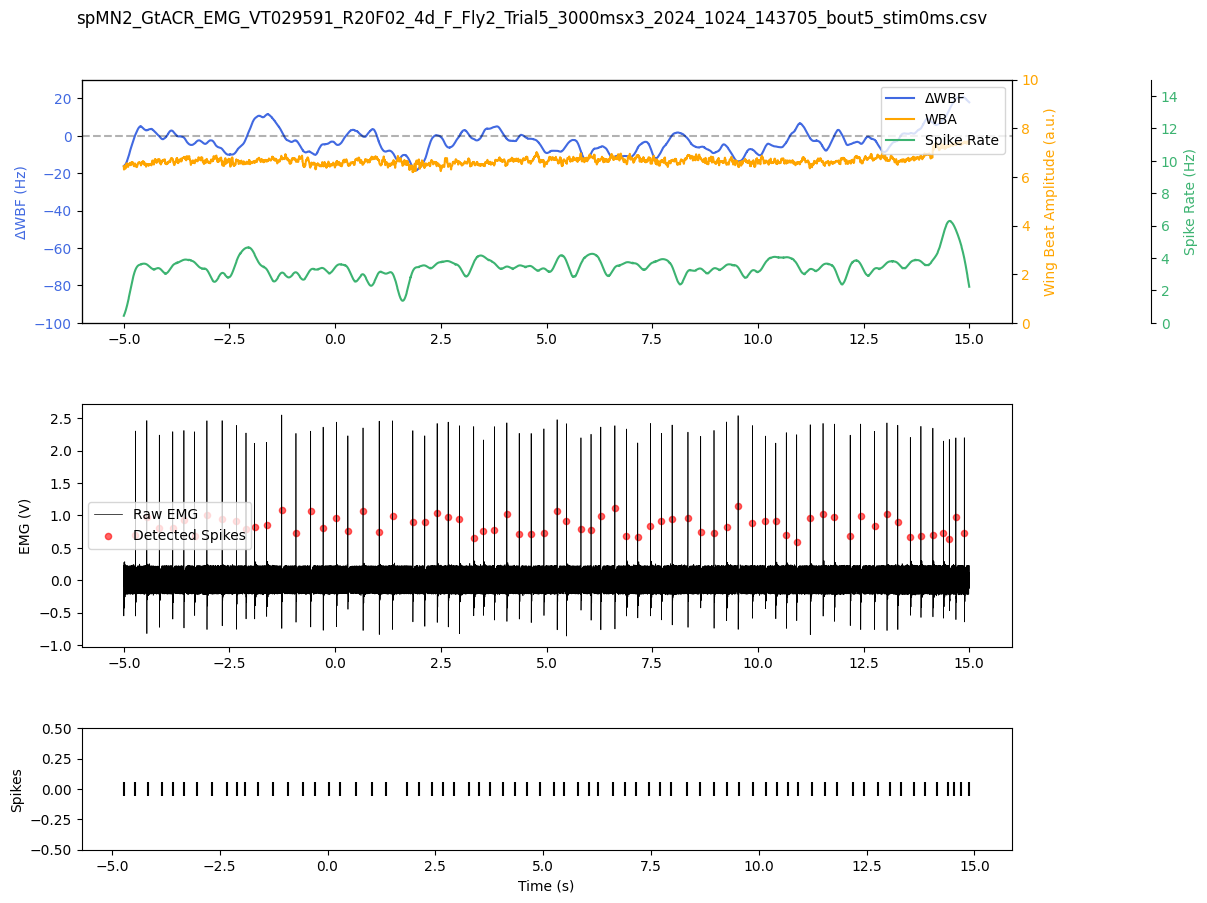

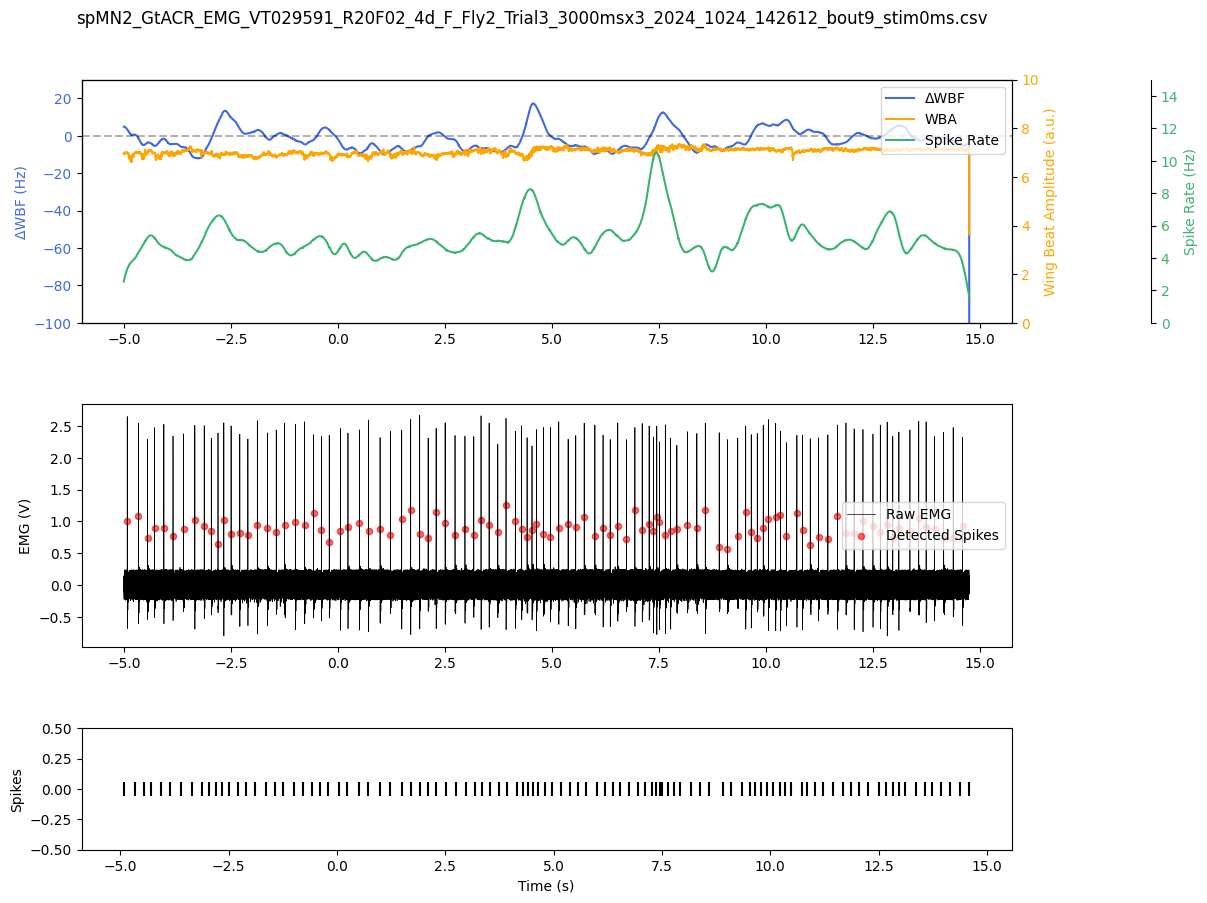

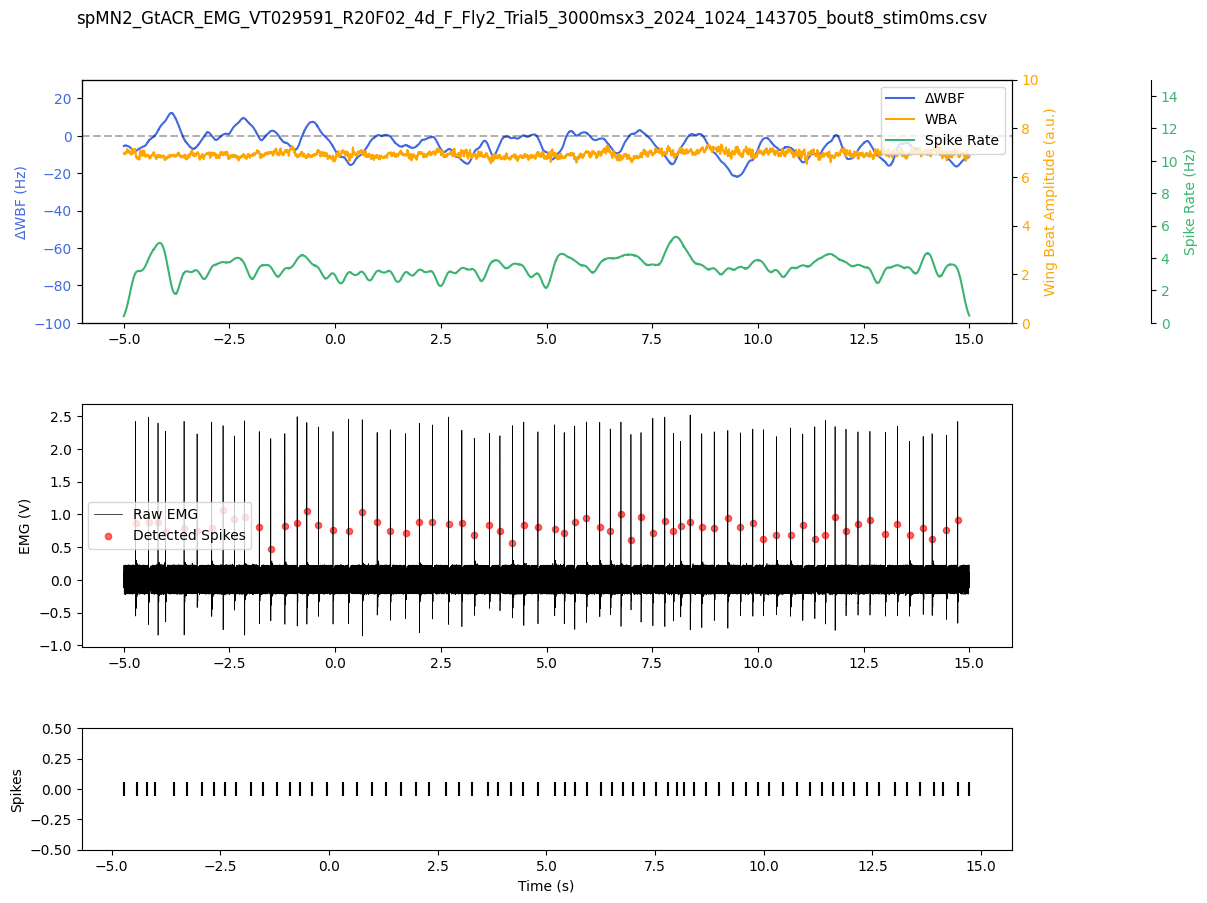

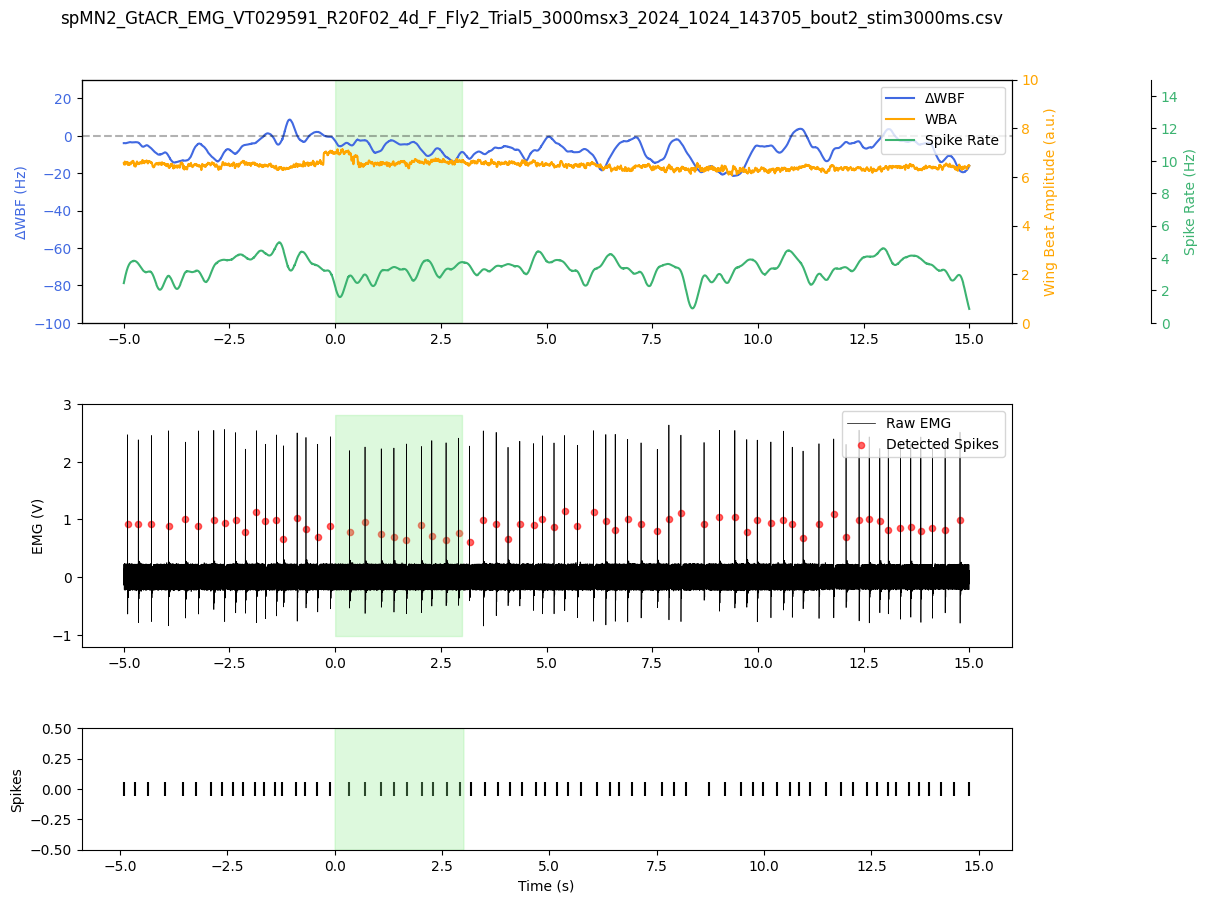

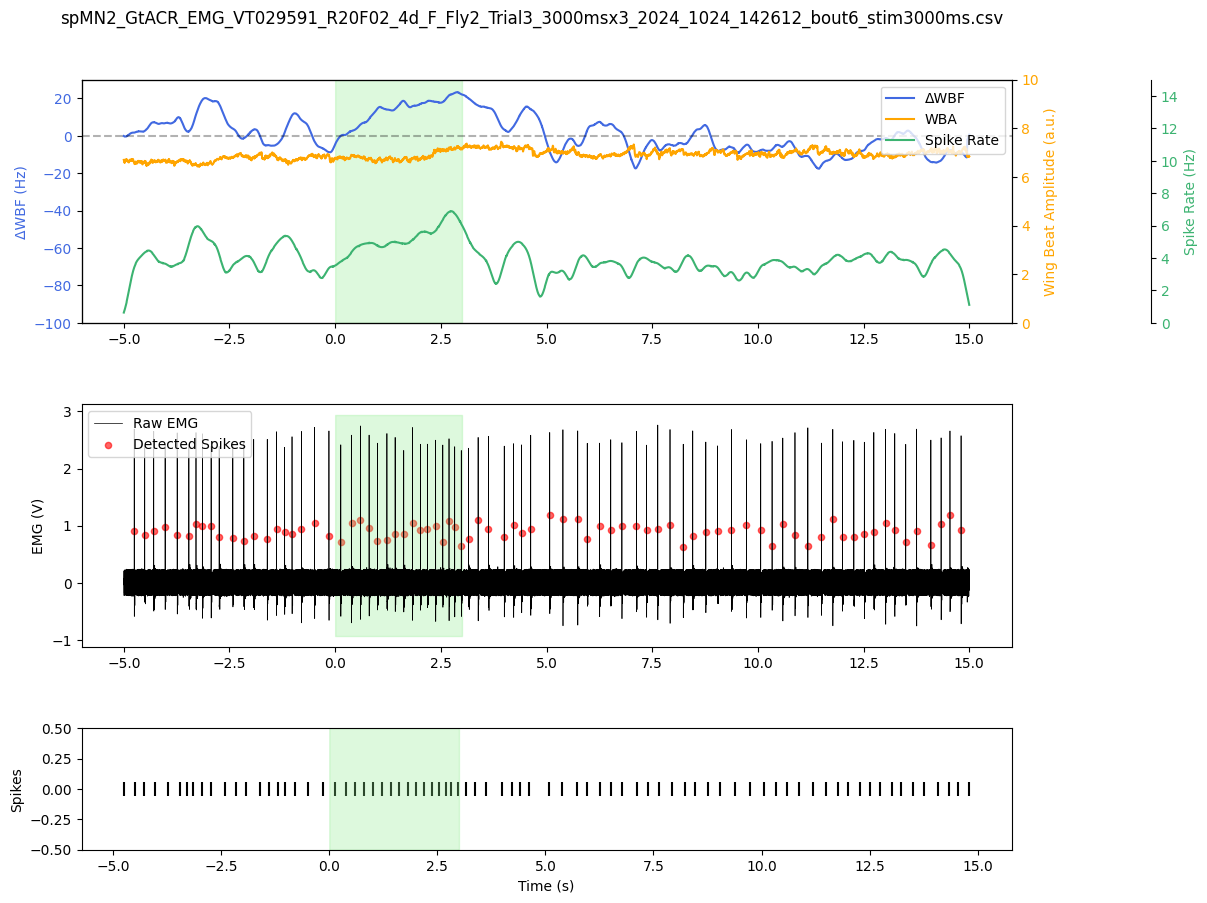

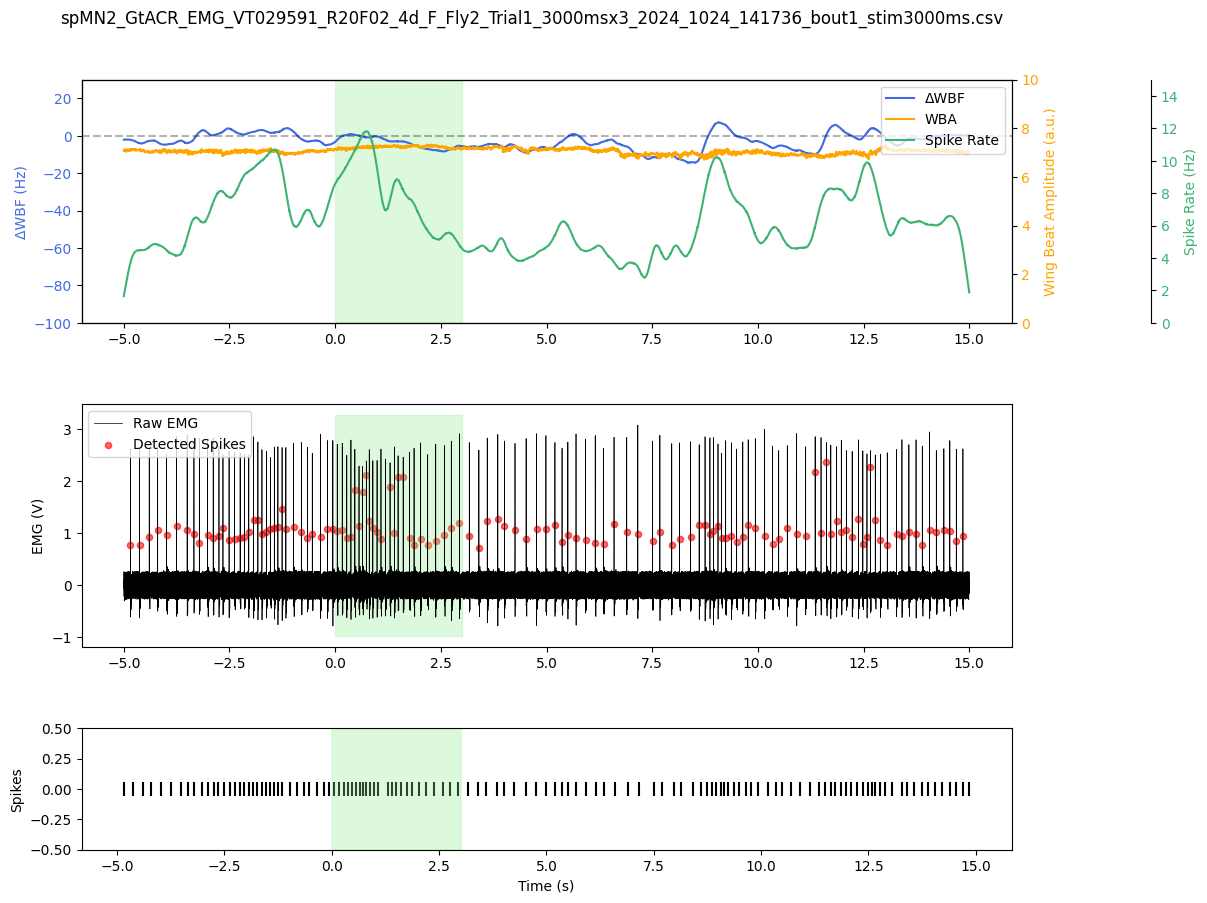

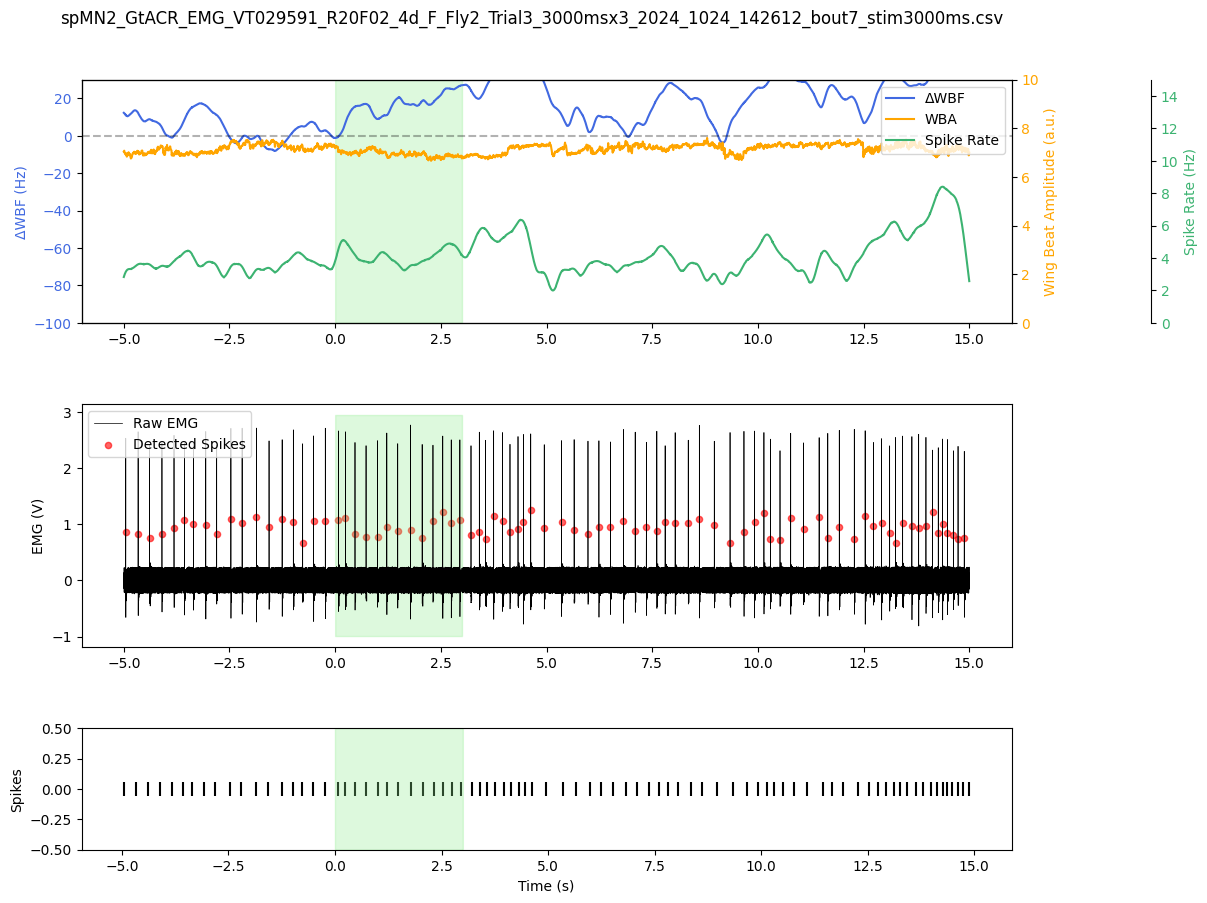

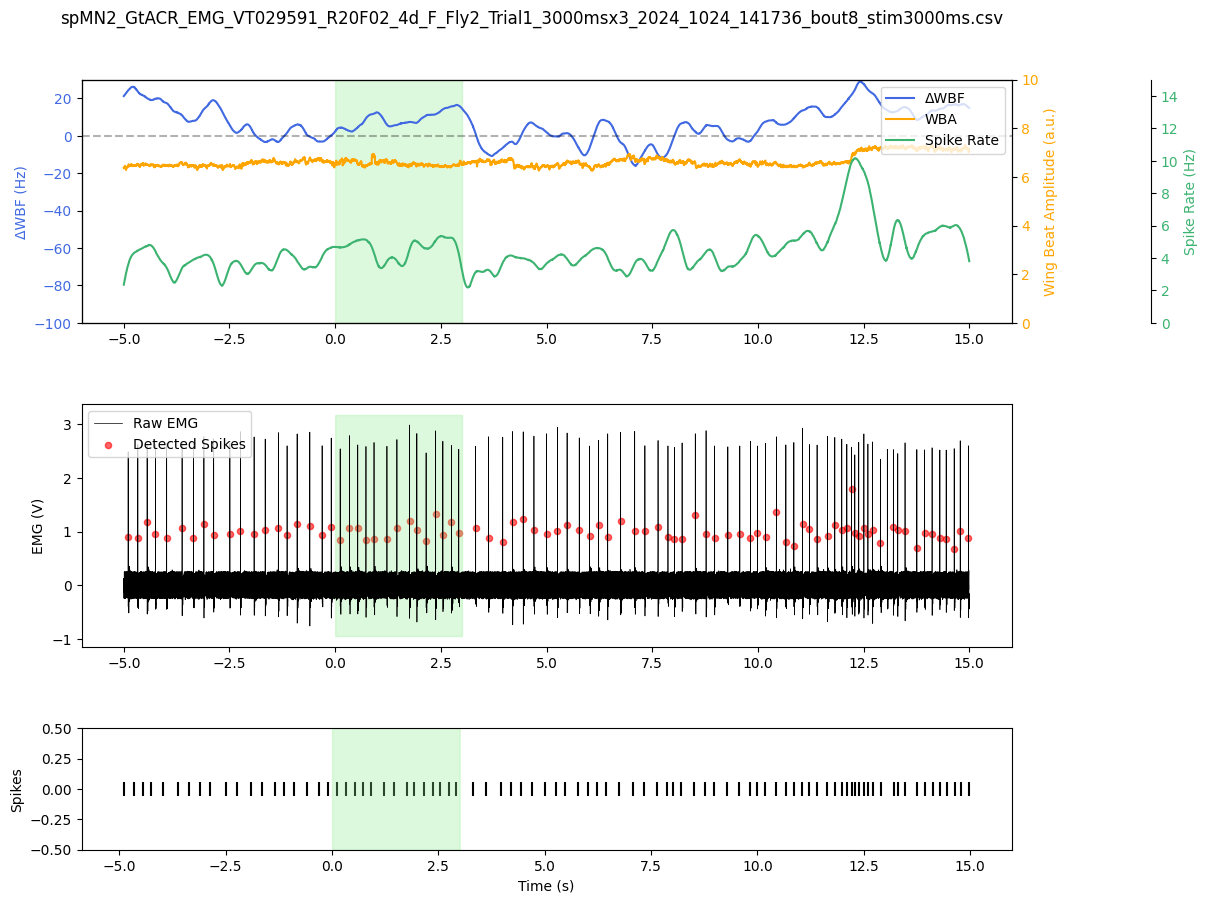

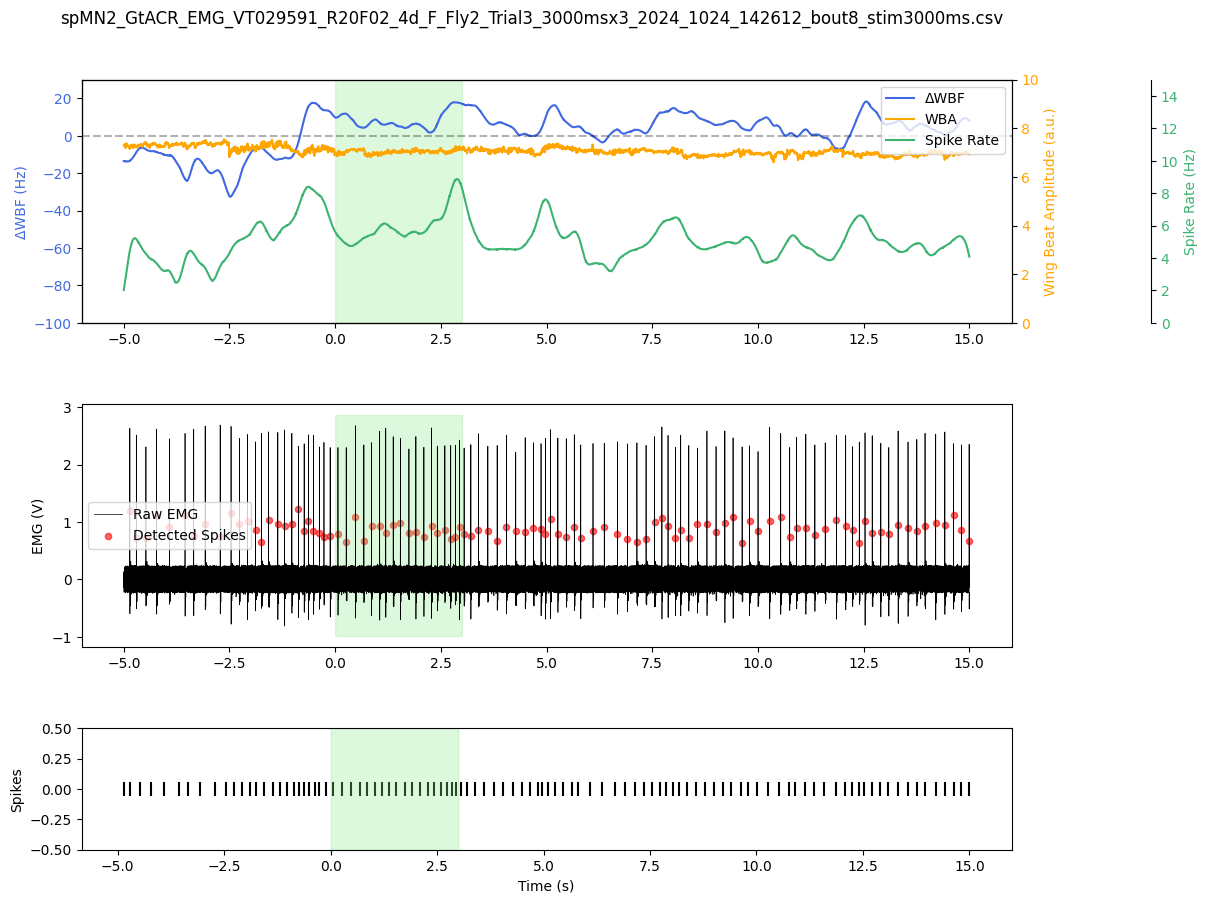

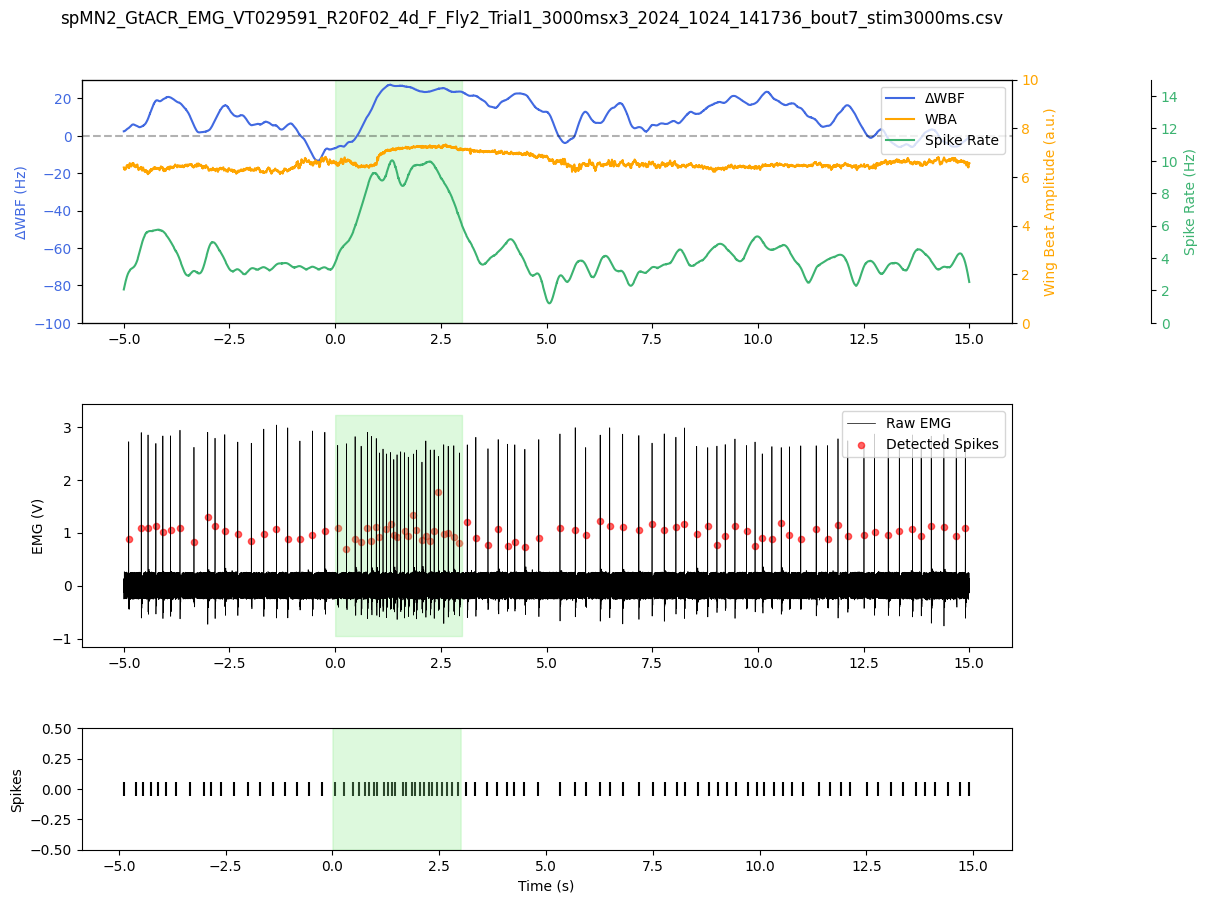

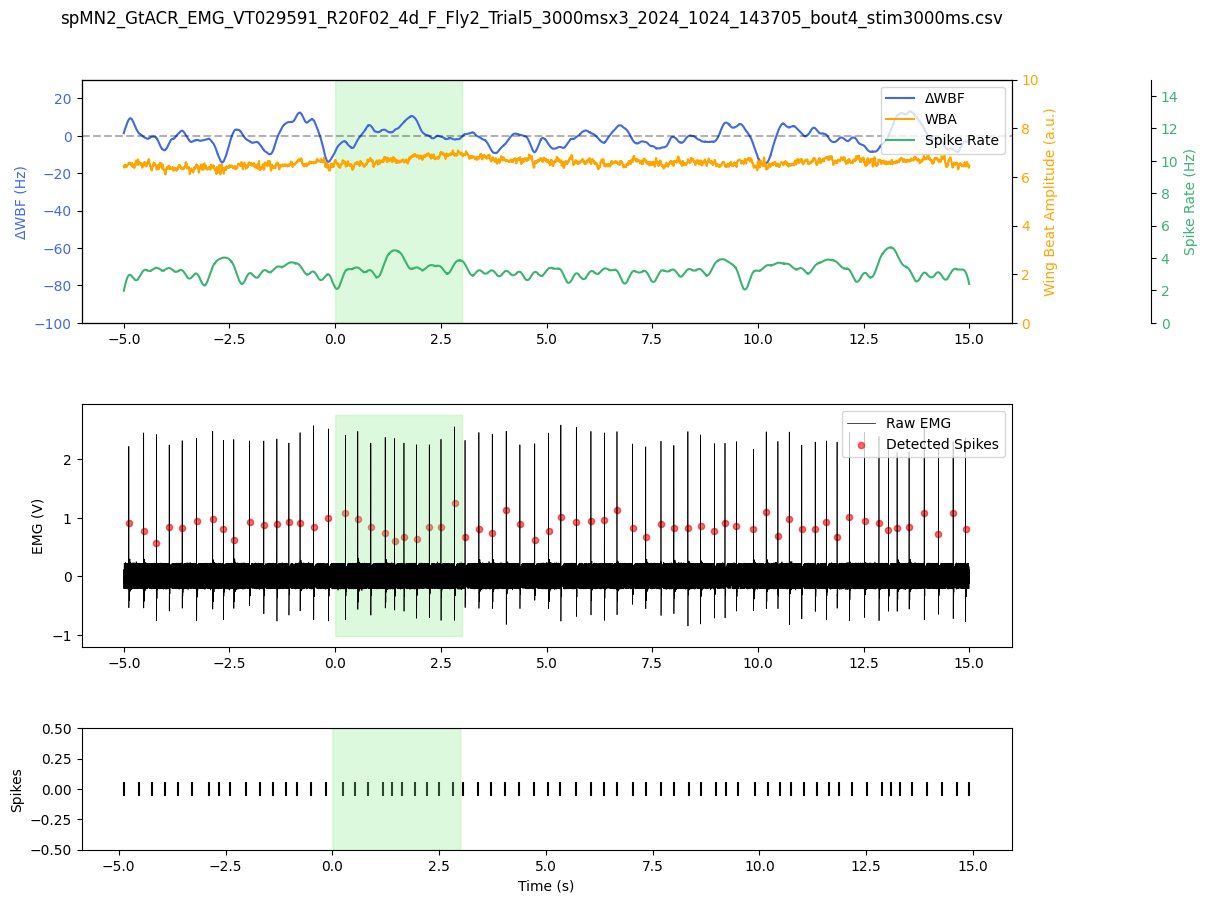

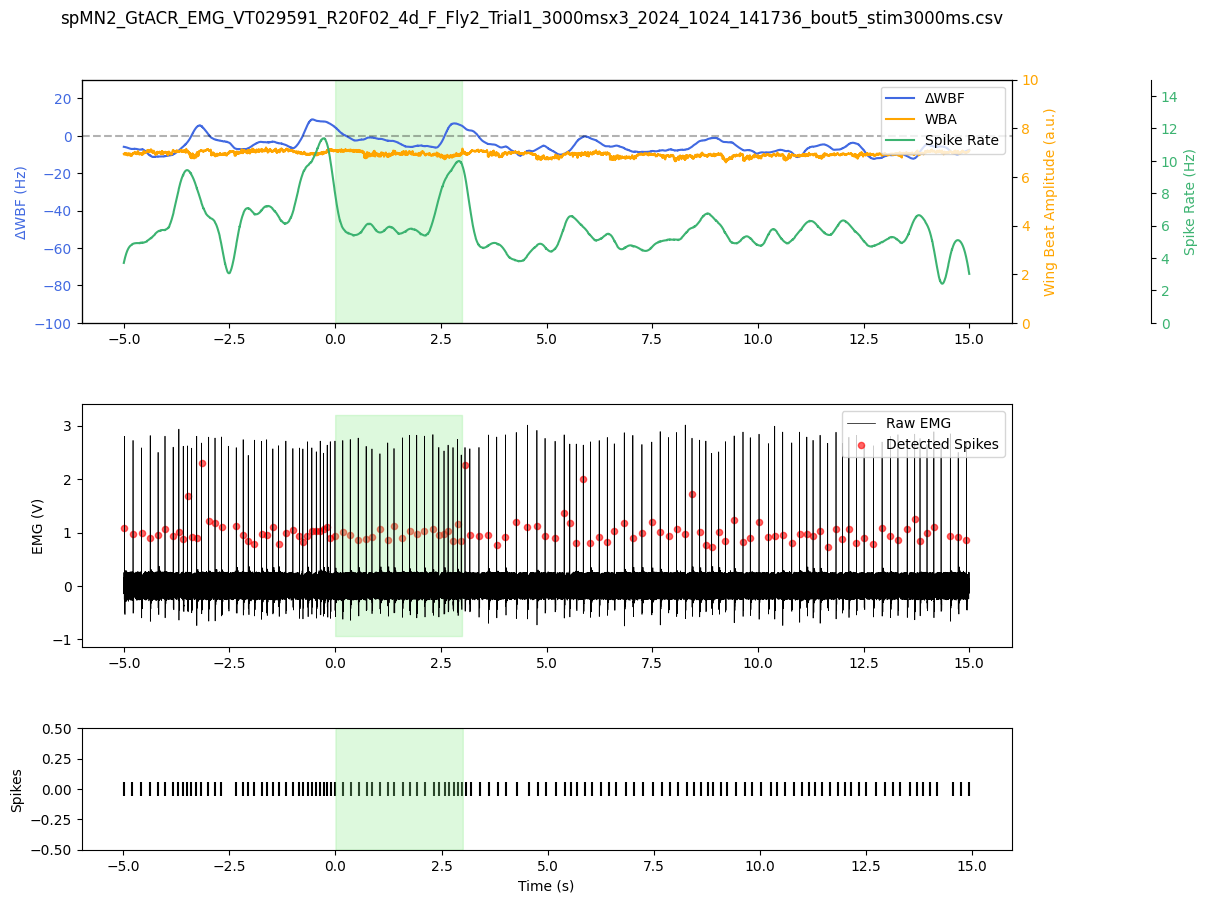

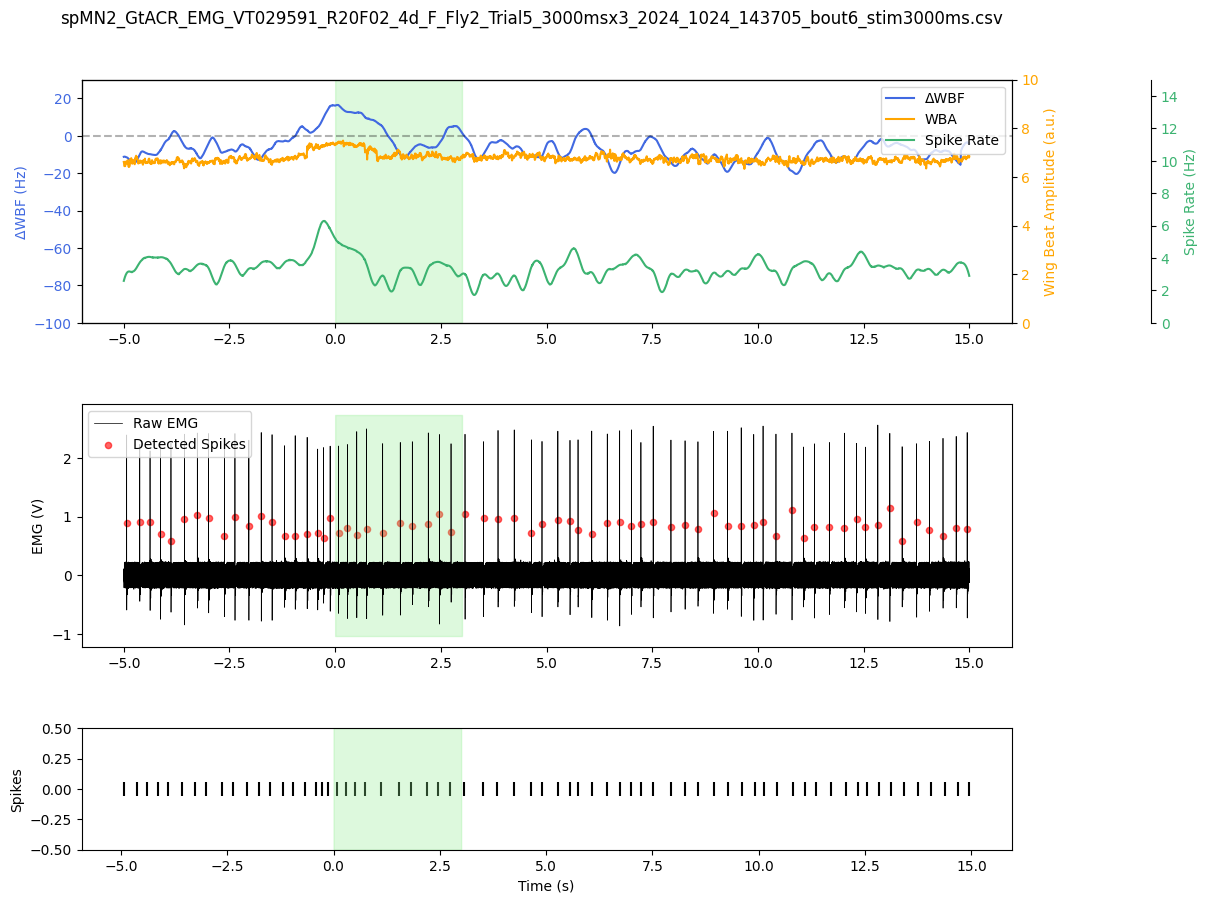

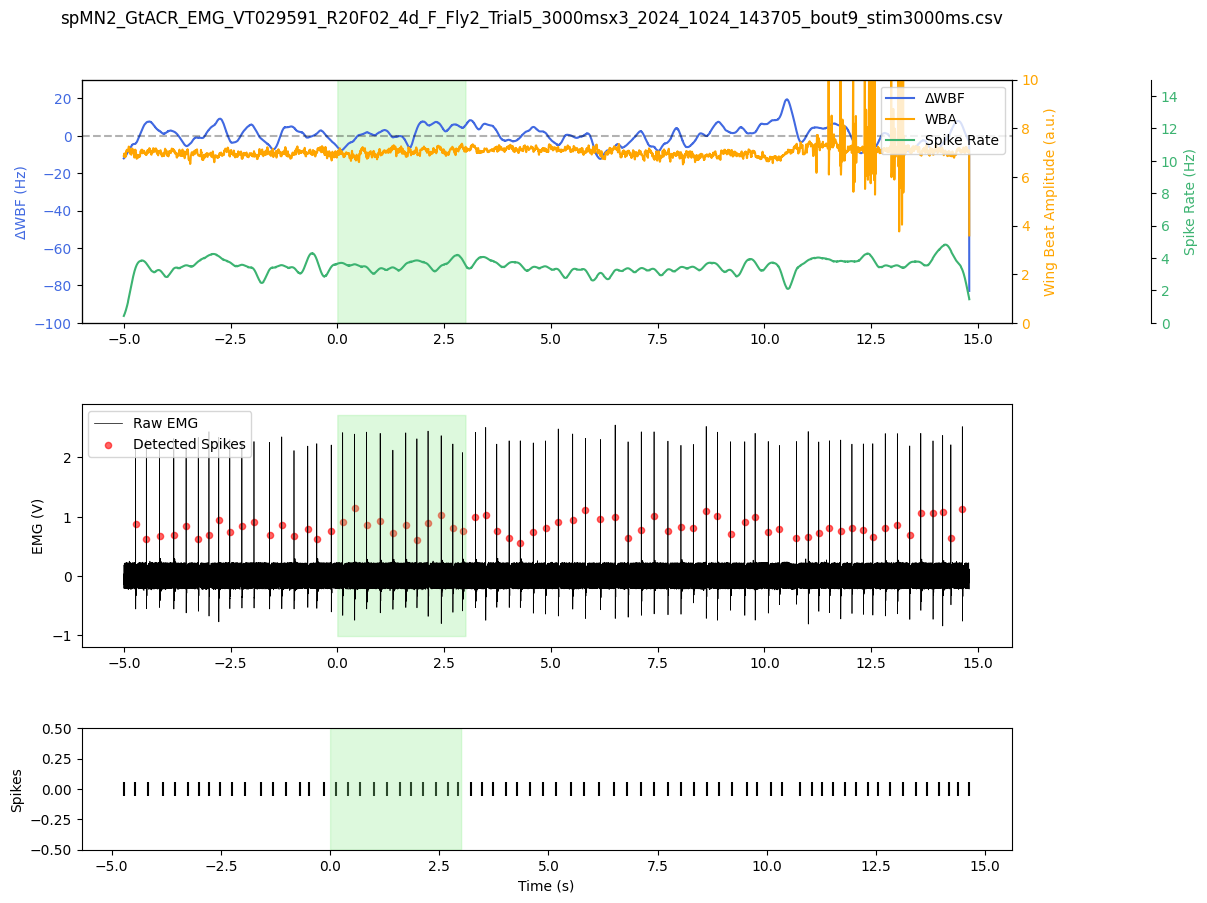

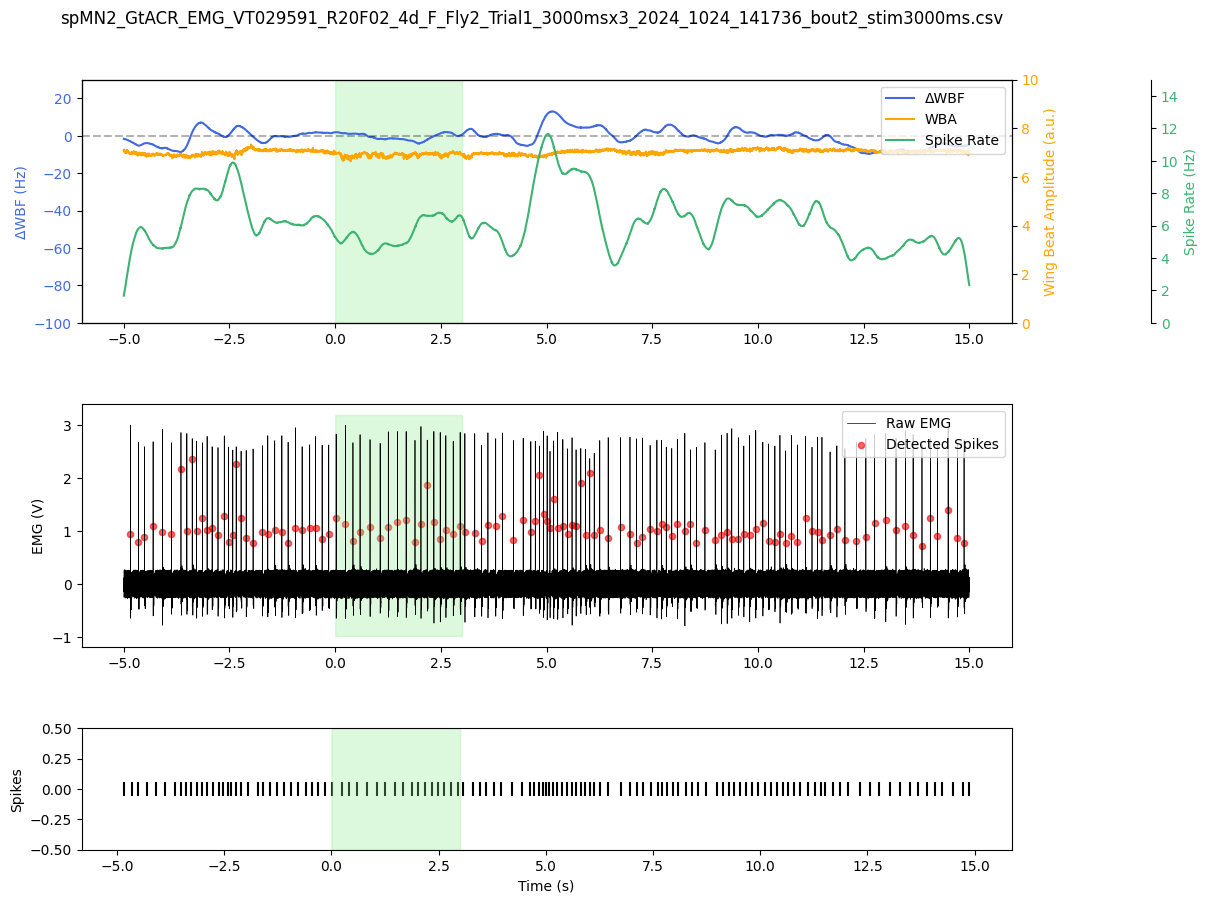

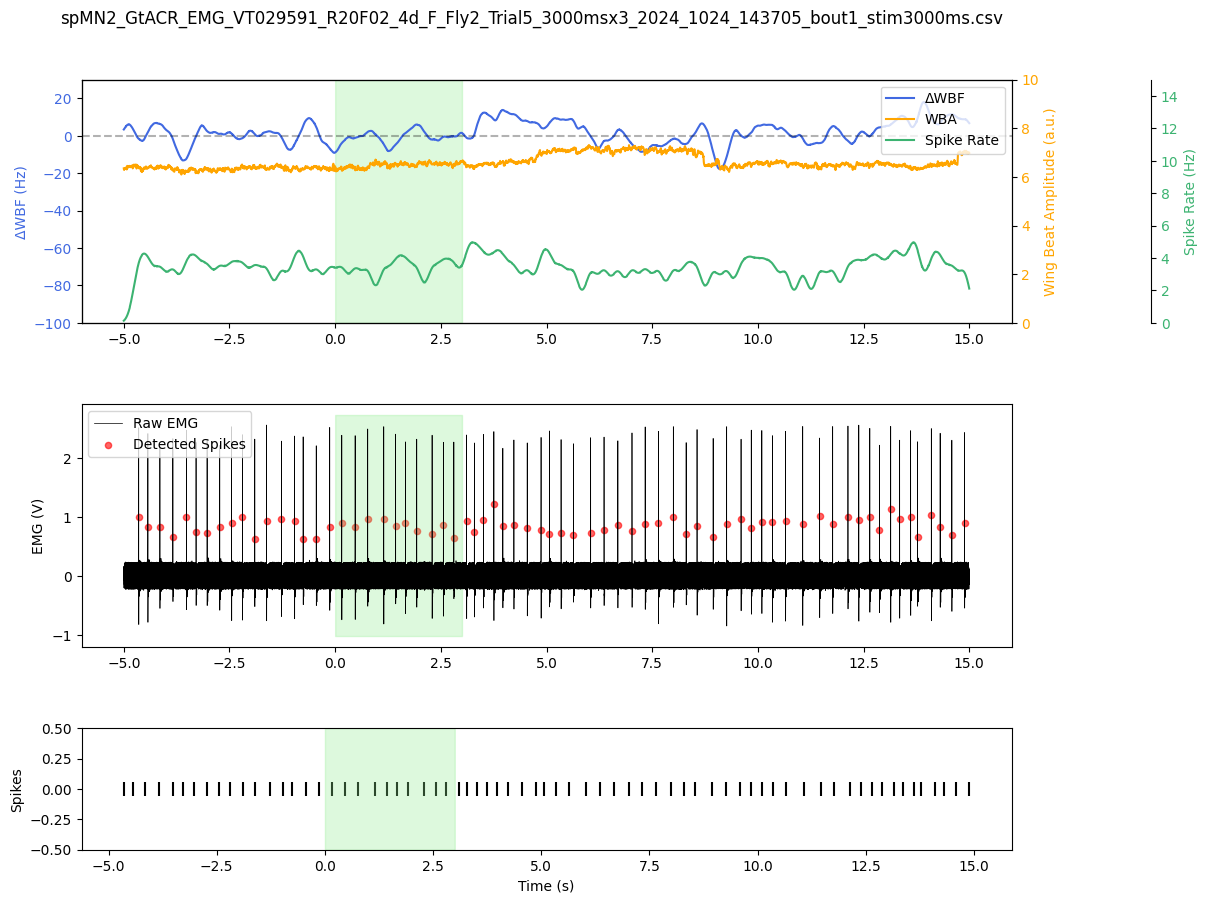

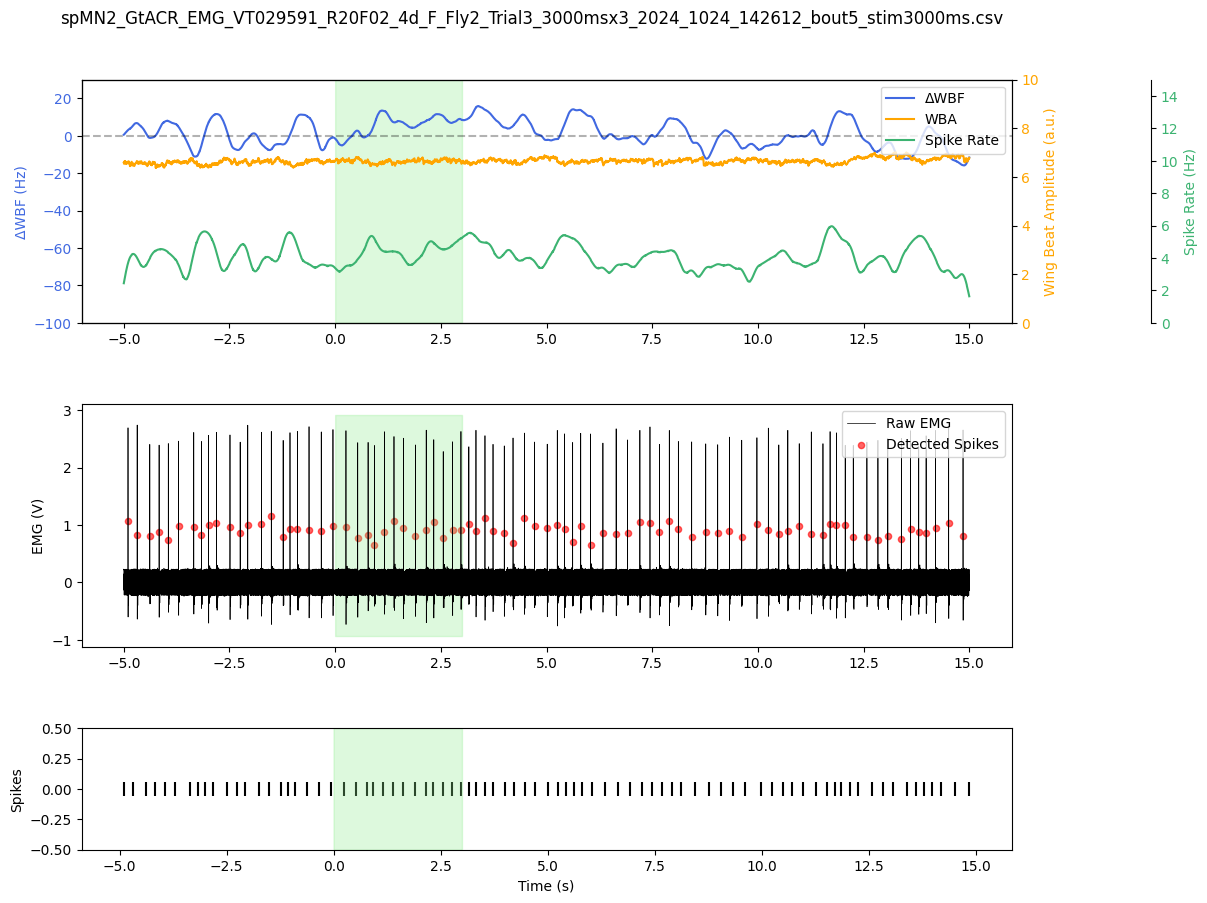

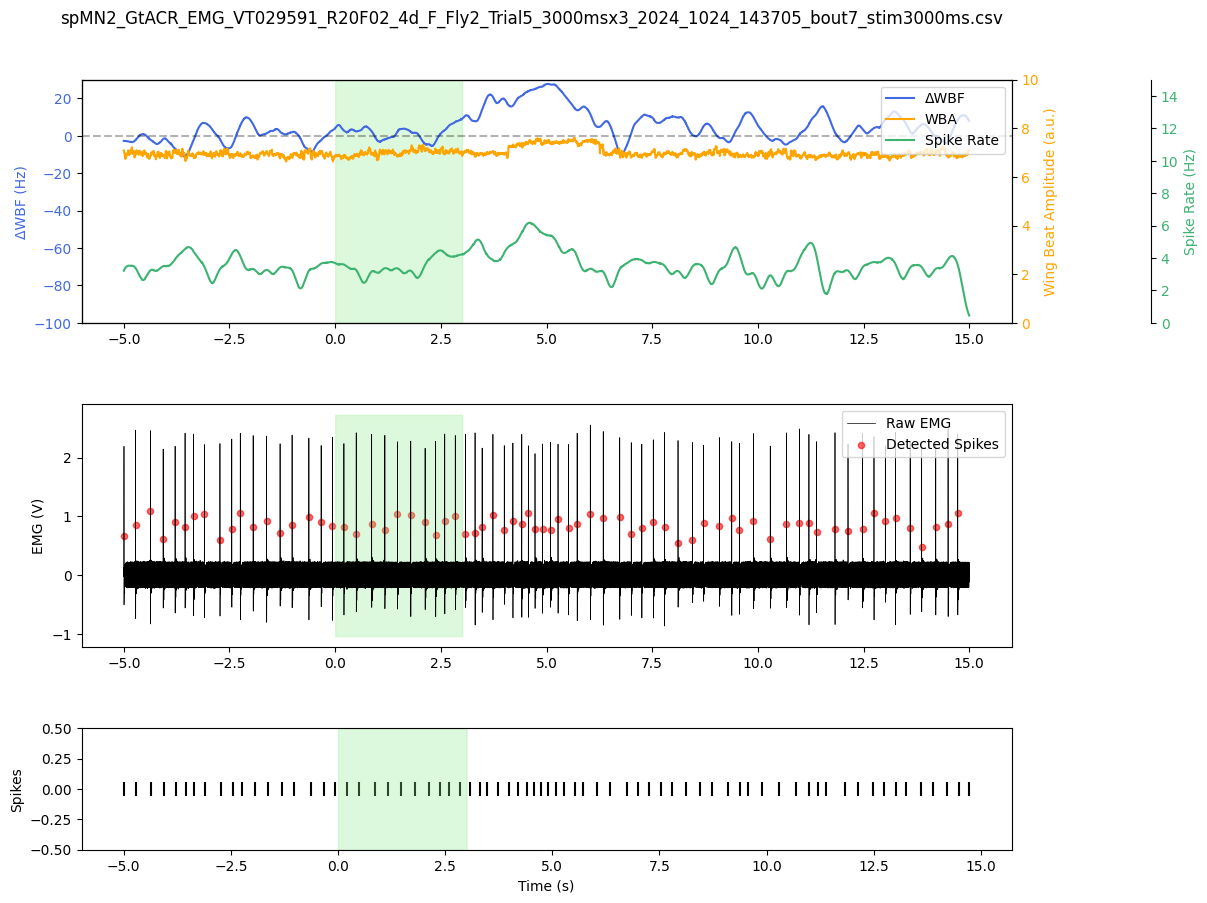

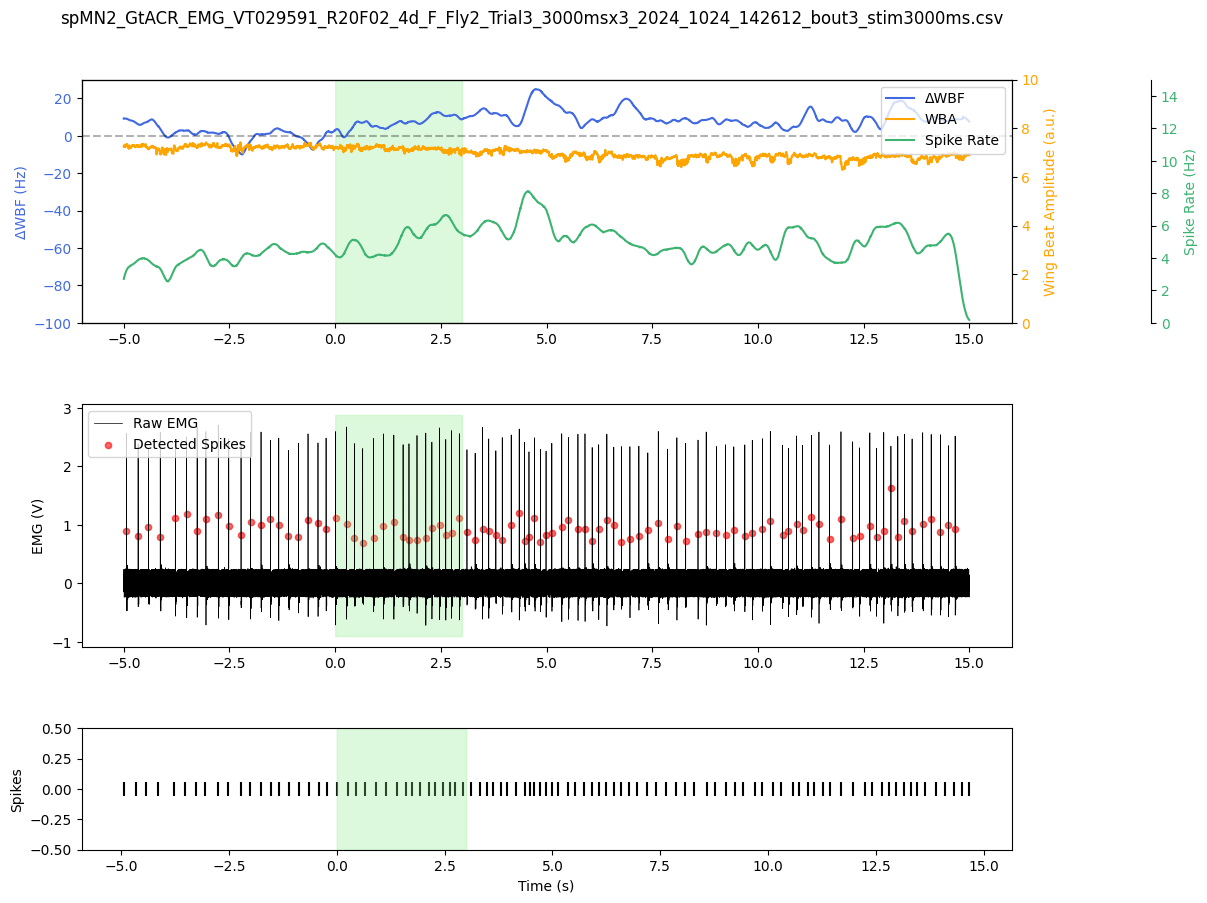

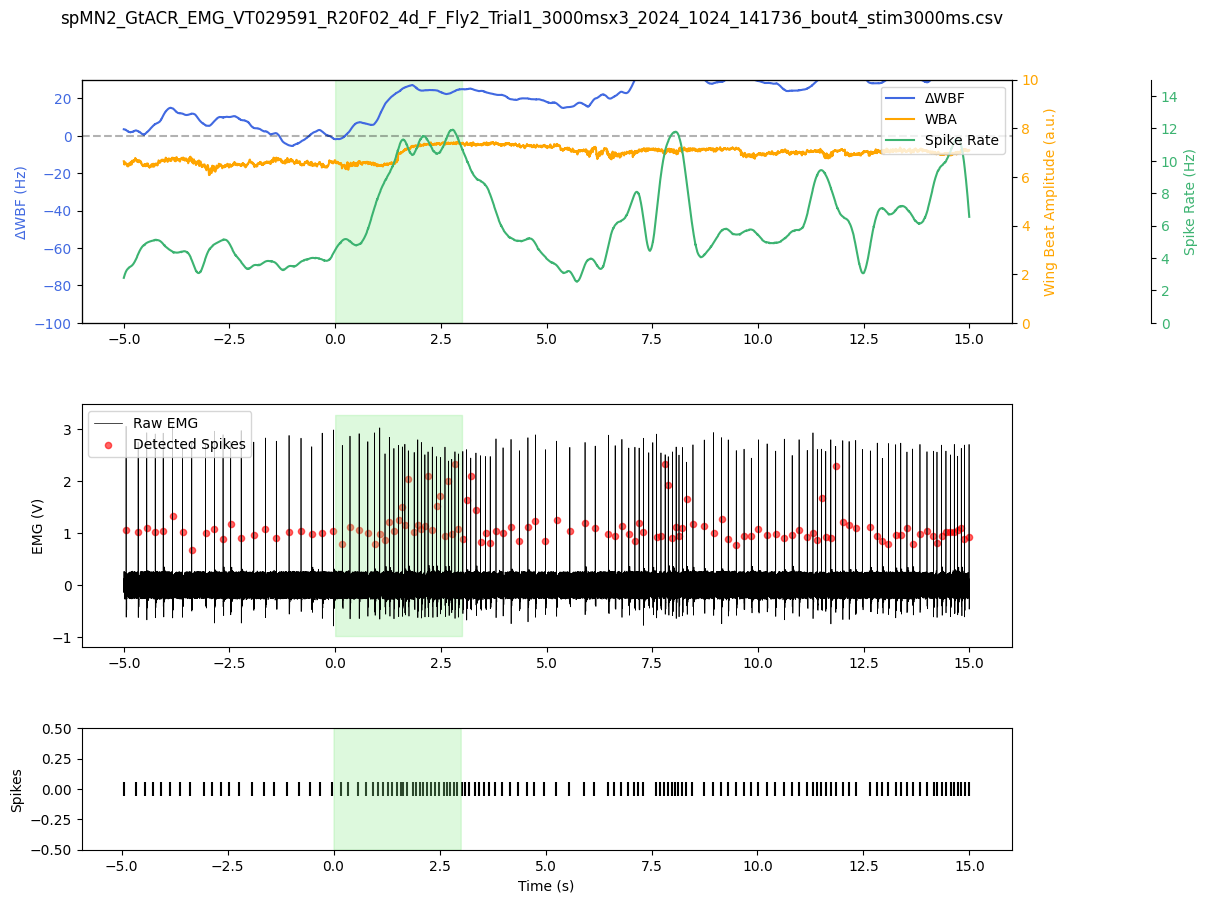

In [ ]:
# Step 3, check the quality of filtered spikes. Will need to remove certain bouts manually afterwards.

import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path

def plot_filtered_data():
    # Get filtered data directory. This is usually the "output_csv_spikefiltered" folder.
    filtered_dir = Path('/Users/camellyc/Library/CloudStorage/GoogleDrive-yichen@tuthill.casa/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/Yichen/Spiracle/Spiracle Imaging/EMG_Analysis/3_spSN_ChR/241122_spSN_ChR_EMG_Fly2_Y/output_csv_spikefiltered')
    
    # Create output directory for plots
    plot_dir = filtered_dir / 'output_plots'
    plot_dir.mkdir(exist_ok=True)
    
    # Process each subdirectory (different stim times)
    for stim_dir in filtered_dir.iterdir():
        if stim_dir.is_dir():
            plot_subdir = plot_dir / stim_dir.name
            plot_subdir.mkdir(exist_ok=True)
            
            # Plot each CSV file
            for csv_file in stim_dir.glob('*.csv'):
                plot_single_bout(str(csv_file), output_dir=str(plot_subdir))

if __name__ == "__main__":
    plot_filtered_data()